In [1]:
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy.signal as signal
import numpy as np
from pystoi import stoi
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier 

2024-08-27 09:39:59.606936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 09:39:59.633617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 09:39:59.641429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 09:39:59.660579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 09:40:01.293818: W tensorflow/compiler/tf2

# Data Loading

In [2]:
DATASET_URL = 'https://www.kaggle.com/datasets/mersico/dangerous-heartbeat-dataset-dhd'

In [3]:
#import dataset as dataframe
data_labels = pd.read_csv('DHD/labels.csv')
metadata = pd.read_csv('DHD/metadata.csv')

# Exploratory Data Analysis

In [4]:
data_labels.head()

set                    filename     label
0   A  artifact__201012172012.wav  artifact
1   A  artifact__201105040918.wav  artifact
2   A  artifact__201105041959.wav  artifact
3   A  artifact__201105051017.wav  artifact
4   A  artifact__201105060108.wav  artifact

In [5]:
metadata.head()

sample_rate  num_frames  num_channels  bits_per_sample encoding  duration  \
0        44100      396900             1               16    PCM_S       9.0   
1        44100      396900             1               16    PCM_S       9.0   
2        44100      396900             1               16    PCM_S       9.0   
3        44100      396900             1               16    PCM_S       9.0   
4        44100      396900             1               16    PCM_S       9.0   

                     filename  
0  artifact__201012172012.wav  
1  artifact__201105040918.wav  
2  artifact__201105041959.wav  
3  artifact__201105051017.wav  
4  artifact__201105060108.wav

In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_rate      661 non-null    int64  
 1   num_frames       661 non-null    int64  
 2   num_channels     661 non-null    int64  
 3   bits_per_sample  661 non-null    int64  
 4   encoding         661 non-null    object 
 5   duration         661 non-null    float64
 6   filename         661 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 36.3+ KB


In [7]:
label_count = data_labels['label'].value_counts()
label_percentages = label_count / label_count.sum() * 100

/tmp/ipykernel_49816/995166641.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_count.index, y=label_count.values, palette='viridis')


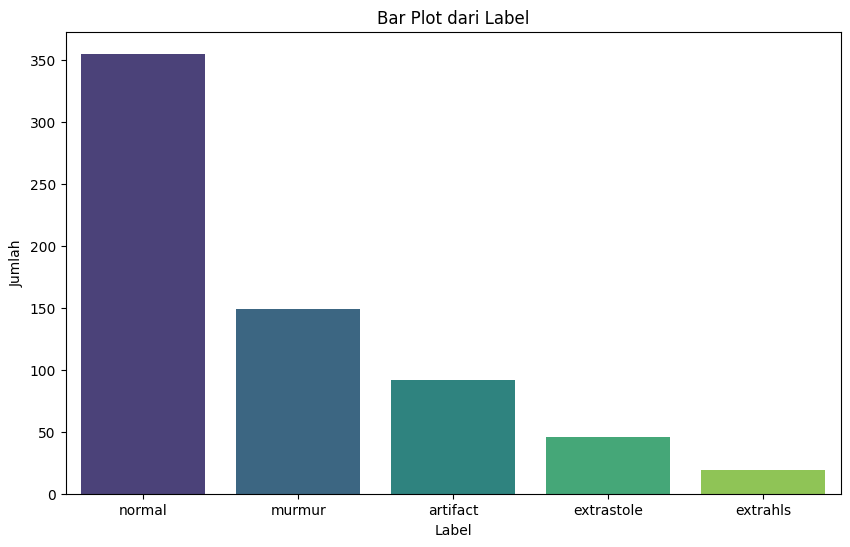

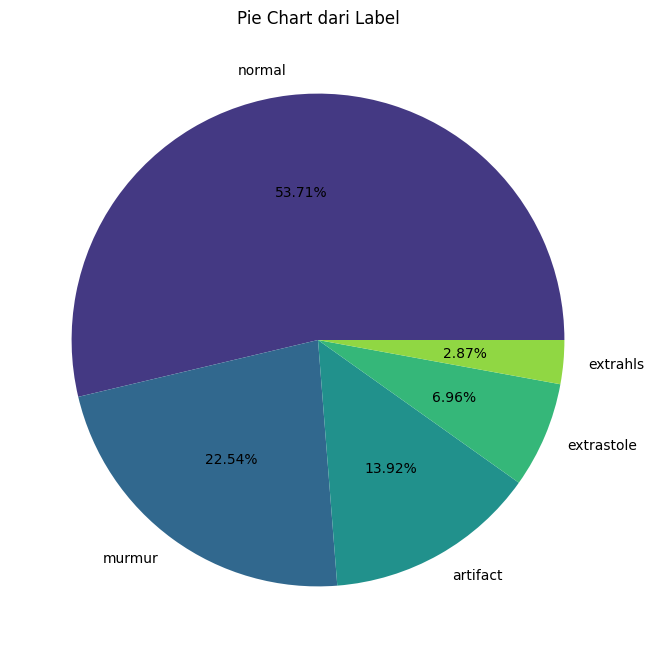

In [8]:
# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_count.index, y=label_count.values, palette='viridis')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Bar Plot dari Label')
plt.show()

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_percentages, labels=label_percentages.index, autopct='%1.2f%%', colors=sns.color_palette('viridis', len(label_percentages)))
plt.title('Pie Chart dari Label')
plt.show()

Label yang ada pada data penyakit jantung ini terdiri dari Normal, murmur, artifact, extrastole, dan extrahls. Namun, data yang diterima tidak seimbang terlihat Normal lebih dominan.

In [9]:
metadata.describe()

sample_rate    num_frames  num_channels  bits_per_sample    duration
count    661.000000  6.610000e+02    661.000000            661.0  661.000000
mean   15757.791225  2.196370e+05      1.083207             16.0    9.066551
std    18400.922135  6.313720e+05      0.276404              0.0   13.263770
min     4000.000000  3.053000e+03      1.000000             16.0    0.760000
25%     4000.000000  1.504600e+04      1.000000             16.0    3.620000
50%     4000.000000  3.522900e+04      1.000000             16.0    7.390000
75%    44100.000000  3.309340e+05      1.000000             16.0    9.770000
max    48000.000000  1.008000e+07      2.000000             16.0  210.000000

Terlihat adanya ketidakseragaman pada fitur sample_rate dan num_channels

In [10]:
sample_rate_count = metadata['sample_rate'].value_counts()
sample_rate_percentages = sample_rate_count / sample_rate_count.sum() * 100

/tmp/ipykernel_49816/2799965780.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sample_rate_count.index, y=sample_rate_count.values, palette='viridis')


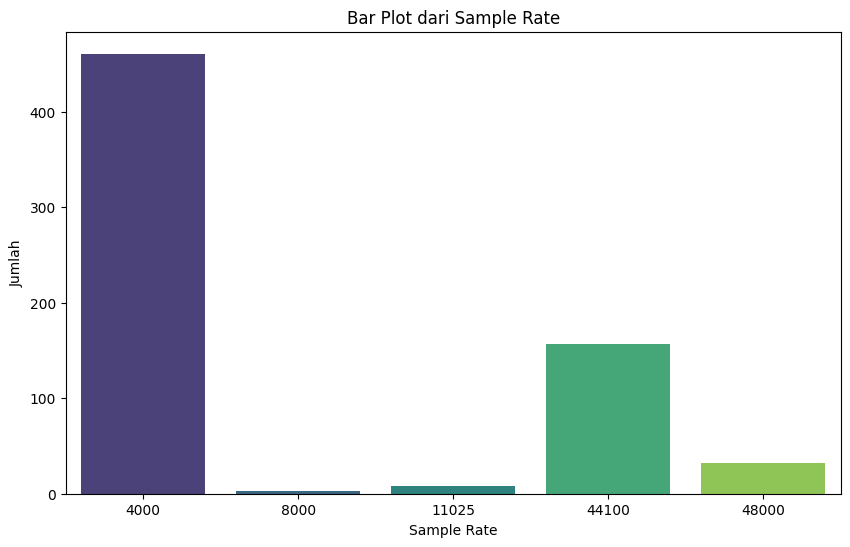

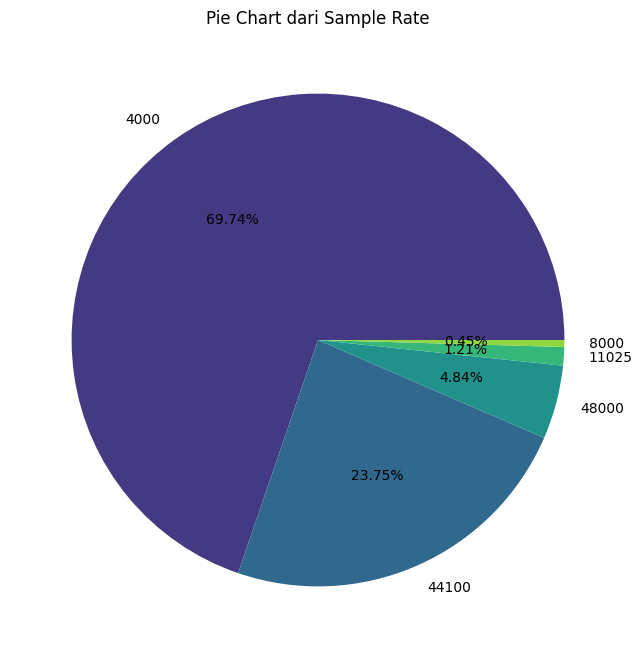

In [11]:
# Membuat bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sample_rate_count.index, y=sample_rate_count.values, palette='viridis')
plt.xlabel('Sample Rate')
plt.ylabel('Jumlah')
plt.title('Bar Plot dari Sample Rate')
plt.show()

# Membuat pie chart
plt.figure(figsize=(8, 8))
plt.pie(sample_rate_percentages, labels=sample_rate_percentages.index, autopct='%1.2f%%', colors=sns.color_palette('viridis', len(sample_rate_percentages)))
plt.title('Pie Chart dari Sample Rate')
plt.show()

Terdapat beberapa jenis sample rate pada data audio, kita akan mengonversi semuanya ke 44100 agar agar ekstraksi fitur yang kita lakukan memiliki informasi fitur sample rate yang sama

In [12]:
channel_count = metadata['num_channels'].value_counts()
channel_percentages = channel_count / channel_count.sum() * 100

/tmp/ipykernel_49816/4273990914.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_count.index, y=channel_count.values, palette='viridis')


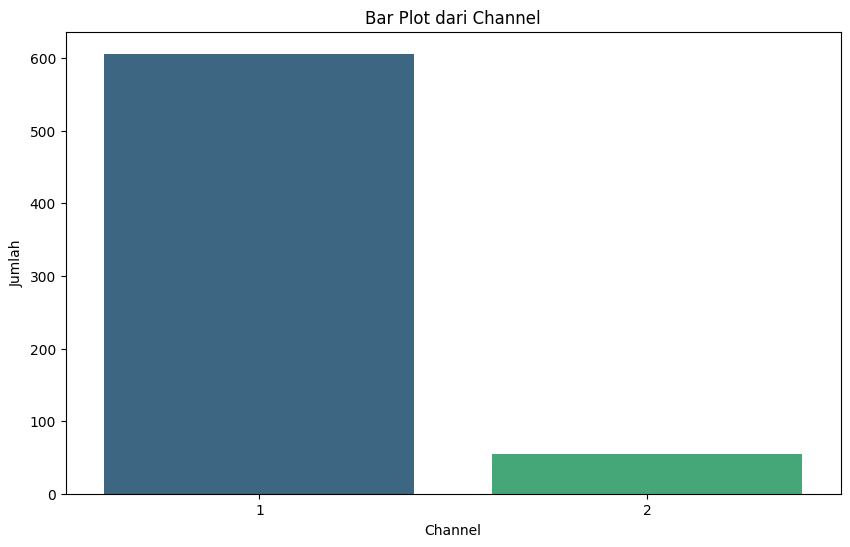

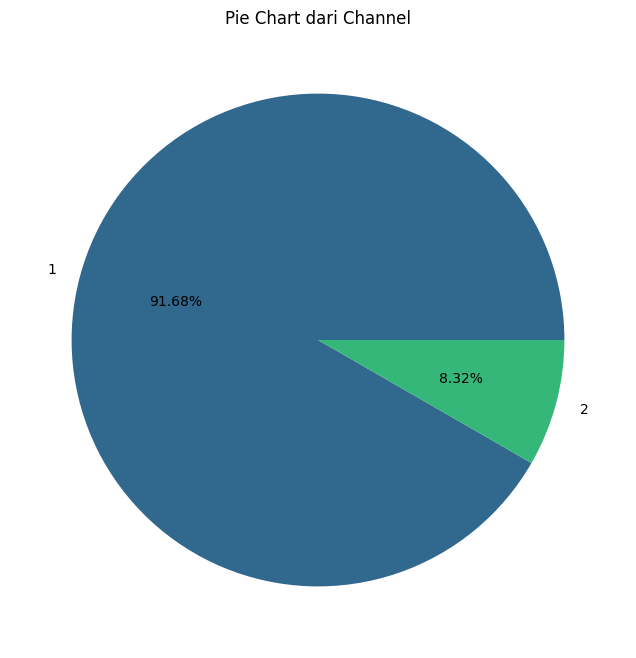

In [13]:
# Membuat bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=channel_count.index, y=channel_count.values, palette='viridis')
plt.xlabel('Channel')
plt.ylabel('Jumlah')
plt.title('Bar Plot dari Channel')
plt.show()

# Membuat pie chart
plt.figure(figsize=(8, 8))
plt.pie(channel_percentages, labels=channel_percentages.index, autopct='%1.2f%%', colors=sns.color_palette('viridis', len(channel_percentages)))
plt.title('Pie Chart dari Channel')
plt.show()

Ditemukan data Wav dengan channel stereo (2) sementara kita hanya memerlukan data mono saja (1) kita akan mengonversi data wav tersebut ke mono agar ekstraksi fitur yang kita lakukan memiliki informasi fitur yang sama yaitu mono

# Data Preprocessing #1

## Data Preparation

In [14]:
#convert semua sample rate ke 44100 Hz
for i in metadata['filename']:
    audio_file = f'DHD/audio/{i}'
    y, sr = librosa.load(audio_file, sr=None)
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=44100)
    sf.write(f'DHD/resample_audio/{i[:-4]}_resampled.wav', y_resampled, 44100)

In [15]:
sampling_rates_resampled = []

for i in metadata['filename']:
    data = i[:-4]
    y, sr = librosa.load(f'DHD/resample_audio/{data}_resampled.wav', sr=None)
    sampling_rates_resampled.append(sr)

sampling_rates_df = pd.DataFrame(sampling_rates_resampled, columns=['Sampling Rate'])

sampling_rates_count = sampling_rates_df['Sampling Rate'].value_counts()
sampling_rate_percentages = sampling_rates_count / sampling_rates_count.sum() * 100

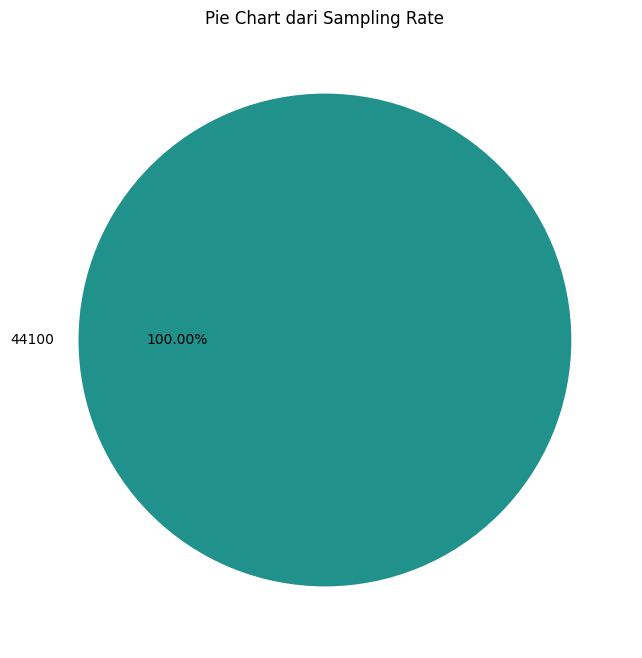

In [16]:
# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(sampling_rate_percentages, labels=sampling_rate_percentages.index, autopct='%1.2f%%', colors=sns.color_palette('viridis', len(sampling_rate_percentages)))
plt.title('Pie Chart dari Sampling Rate')
plt.show()

Dapat dilihat bahwa semua sample rate telah berhasil dikonversi ke 44100 Hz

In [17]:
#proses konversi channel
for i in range(len(metadata['filename'])):
    data = metadata['filename'][i][:-4]
    filename = f"DHD/resample_audio/{data}_resampled.wav"
    if metadata['num_channels'][i] == 2:
        y, sr = librosa.load(filename, sr=None, mono=False)
        y_mono = librosa.to_mono(y)
        sf.write(f'DHD/resample_audio_mono/{data}_mono.wav', y_mono, sr)
    else:
        y, sr = librosa.load(filename, sr=None)
        sf.write(f'DHD/resample_audio_mono/{data}_mono.wav', y, sr)

In [18]:
channel_converted = []

for i in range(len(metadata['filename'])):
    data = metadata['filename'][i][:-4]
    y, sr = librosa.load(f'DHD/resample_audio_mono/{data}_mono.wav', sr=None)
    channel_converted.append(y.ndim)

channel_converted_df = pd.DataFrame(channel_converted, columns=['Channel'])

channel_converted_count = channel_converted_df['Channel'].value_counts()
channel_converted_percentage = channel_converted_count / channel_converted_count.sum() * 100

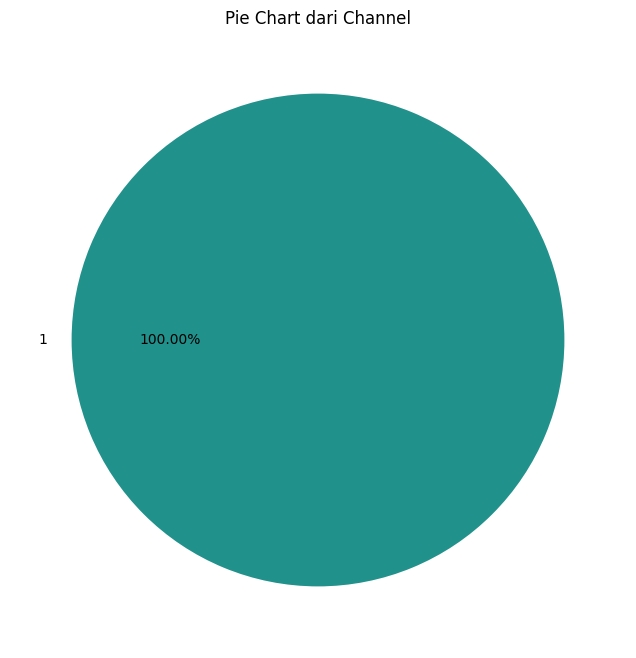

In [19]:
# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(channel_converted_percentage, labels=channel_converted_percentage.index, autopct='%1.2f%%', colors=sns.color_palette('viridis', len(channel_converted_percentage)))
plt.title('Pie Chart dari Channel')
plt.show()

Dapat dilihat bahwa semua channel telah berhasil dikonversi ke Mono

## Denoising

In [20]:
# Audio Denosing menggunakan FIR
def audio_filter_FIR(audio_file, output_file):
    data, sample_rate = sf.read(audio_file)

    # Parameters untuk FIR filter
    cutoff_freq = 4000.0
    filter_order = 100

    # Normalisasi cutoff frequency
    nyquist_rate = sample_rate / 2.0
    normalized_cutoff = cutoff_freq / nyquist_rate

    # FIR filter with Hamming window
    fir_coefficients = signal.firwin(filter_order, normalized_cutoff, window='hamming')

    filtered_data = signal.lfilter(fir_coefficients, 1.0, data)
    sf.write(output_file, filtered_data, sample_rate)

In [21]:
# proses denoising audio
for i in range(len(metadata['filename'])):
    data = metadata['filename'][i][:-4]
    audio_filter_FIR(f'DHD/resample_audio_mono/{data}_mono.wav', f'DHD/final_audio/{data}_filtered.wav')

In [22]:
stoi_values = []

# proses pengukuran performa denoising
for i in range(len(metadata['filename'])):
    data = metadata['filename'][i][:-4]

    # Load the WAV files
    clean_signal, _ = sf.read(f'DHD/resample_audio_mono/{data}_mono.wav')
    denoised_signal, _ = sf.read(f'DHD/final_audio/{data}_filtered.wav')
    sample_rate = 44100
    
    # Komputasi STOI
    stoi_value = stoi(clean_signal, denoised_signal, sample_rate, extended=False)
    stoi_values.append(stoi_value)


/home/macreai/.local/lib/python3.10/site-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '


In [23]:
stoi_values = np.array(stoi_values)

In [24]:
stoi_average = np.average(stoi_values)

print(stoi_average)

0.9202424067554108


Skor STOI hampir sempurna yaitu 0.92 dari 1, menunjukkan performa denoising yang sangat baik

### Comparation Between Raw Audio and Denoised Audio

In [25]:
raw_audio, sample_rate = sf.read("DHD/resample_audio_mono/artifact_2023_4_mono.wav")
denoised_audio, sample_rate = sf.read("DHD/final_audio/artifact_2023_4_filtered.wav")

min_len = min(len(raw_audio), len(denoised_audio))
raw_audio = raw_audio[:min_len]
denoised_audio = denoised_audio[:min_len]

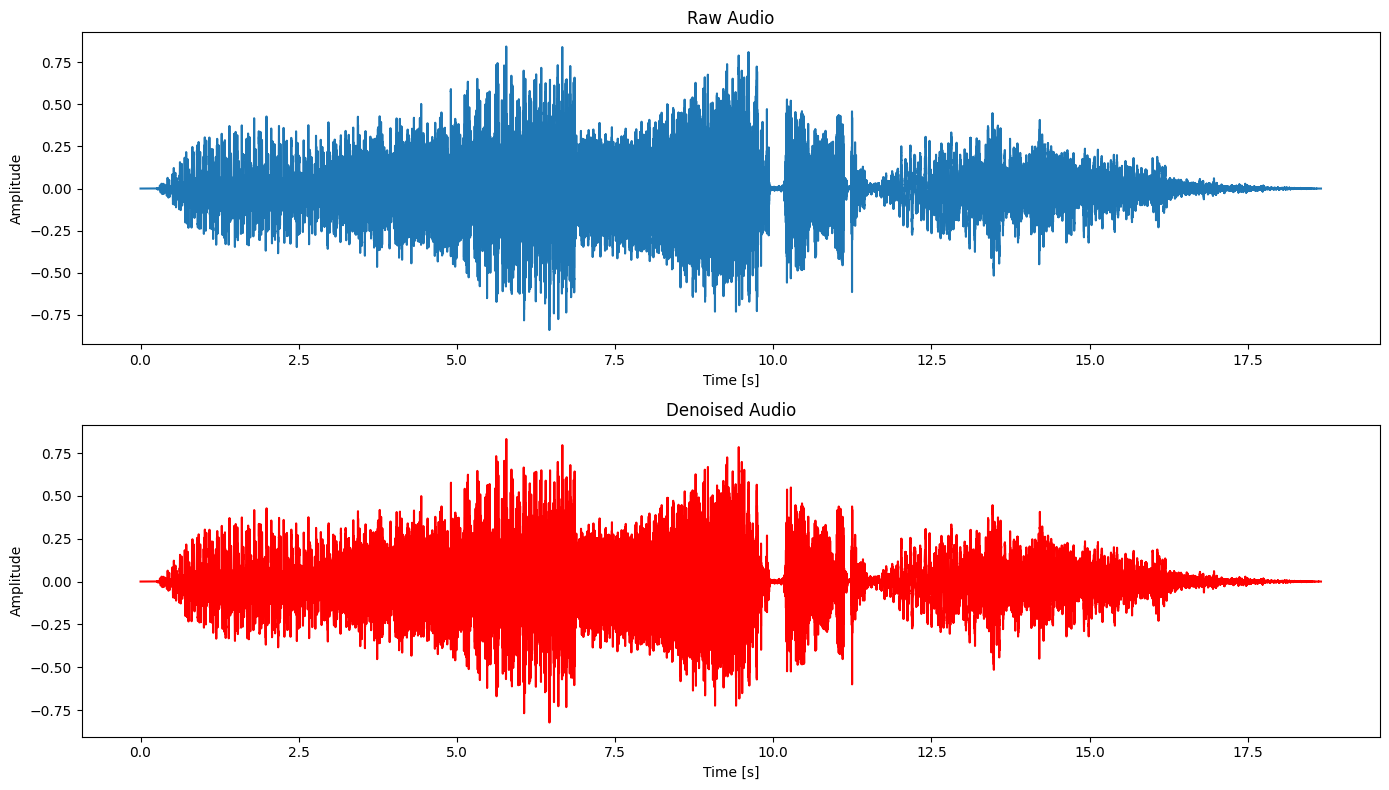

In [26]:
time = np.arange(0, min_len) / sample_rate

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(time, raw_audio, label='Raw Audio')
plt.title('Raw Audio')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time, denoised_audio, label='Denoised Audio', color='red')
plt.title('Denoised Audio')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


Mungkin terlihat bahwa raw audio dan denoised audio tidak berbeda, namun perhatikan pada detik ke-10 perbedaan begitu terlihat. Data yang digunakan merupakan data akademis yang sudah bersih, namun tetap dilakukan denoising untuk meningkatkan performa model yang akan dibuat dan simulasi pada data raw yang akan memiliki noise saat deployment. Hal ini bisa dibuktikan dengan pemutaran audio pada Audio Raw dan yang sudah di-denoising

In [27]:
#Raw Data
play_wav = "DHD/resample_audio_mono/artifact_2023_4_mono.wav"
Audio(play_wav)

In [28]:
#Denoised Data
play_wav = "DHD/final_audio/artifact_2023_4_filtered.wav"
Audio(play_wav)

Terdengar data yang belum di-denoising pun suaranya sudah bersih, kita lanjutkan pada sampel berikutnya

In [29]:
raw_audio, sample_rate = sf.read("DHD/resample_audio_mono/aortic_regurgitation_2023_3_mono.wav")
denoised_audio, sample_rate = sf.read("DHD/final_audio/aortic_regurgitation_2023_3_filtered.wav")

min_len = min(len(raw_audio), len(denoised_audio))
raw_audio = raw_audio[:min_len]
denoised_audio = denoised_audio[:min_len]

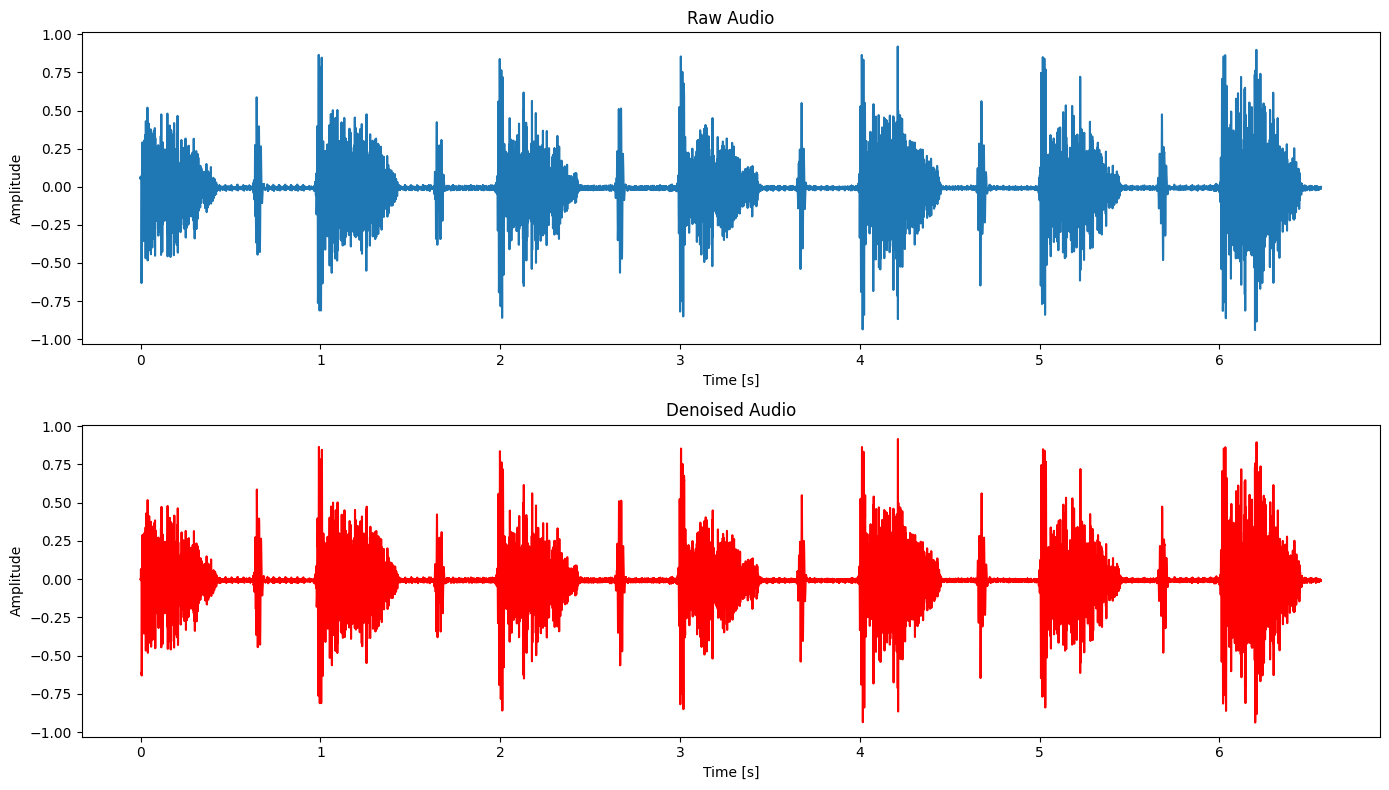

In [30]:
time = np.arange(0, min_len) / sample_rate

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(time, raw_audio, label='Raw Audio')
plt.title('Raw Audio')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time, denoised_audio, label='Denoised Audio', color='red')
plt.title('Denoised Audio')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

Pada data sampel kali ini pun data denoised dan data raw terlihat tidak jauh berbeda, hal ini dibuktikan dari data raw yang memang sudah bersih

In [31]:
#Raw Data
play_wav = "DHD/resample_audio_mono/aortic_regurgitation_2023_3_mono.wav"
Audio(play_wav)

In [32]:
#Denoised Data
play_wav = "DHD/final_audio/aortic_regurgitation_2023_3_filtered.wav"
Audio(play_wav)

In [33]:
#memperbarui metadata label menjadi file yang telah didenoising
data_labels['filename'] = data_labels['filename'].str.replace('.wav', '_filtered.wav')
data_labels.to_csv('DHD/new_labels.csv', index=False)

# Feature Engineering

In [34]:
new_data_labels = pd.read_csv('DHD/new_labels.csv')

In [35]:
new_data_labels.head()

set                             filename     label
0   A  artifact__201012172012_filtered.wav  artifact
1   A  artifact__201105040918_filtered.wav  artifact
2   A  artifact__201105041959_filtered.wav  artifact
3   A  artifact__201105051017_filtered.wav  artifact
4   A  artifact__201105060108_filtered.wav  artifact

In [36]:
def compute_mfcc_features(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    
    mean_mfcc = np.mean(mfcc)
    std_mfcc = np.std(mfcc)
    max_mfcc = np.max(mfcc)
    median_mfcc = np.median(mfcc)
    var_mfcc = np.var(mfcc)
    skewness_mfcc = stats.skew(mfcc.flatten())
    q1_mfcc = np.percentile(mfcc, 25)
    q3_mfcc = np.percentile(mfcc, 75)
    iqr_mfcc = stats.iqr(mfcc.flatten())
    minmax_mfcc = np.ptp(mfcc)
    kurtosis_mfcc = stats.kurtosis(mfcc.flatten())
    
    return {
        'Mean mfcc': mean_mfcc,
        'Std Dev mfcc': std_mfcc,
        'Max mfcc': max_mfcc,
        'Median mfcc': median_mfcc,
        'Variance mfcc': var_mfcc,
        'Skewness mfcc': skewness_mfcc,
        'Quartile 1 mfcc': q1_mfcc,
        'Quartile 3 mfcc': q3_mfcc,
        'IQR mfcc': iqr_mfcc,
        'MinMax mfcc': minmax_mfcc,
        'Kurtosis mfcc': kurtosis_mfcc
    }

In [37]:
def compute_chroma_stft_features(y, sr):
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    
    mean_chroma_stft = np.mean(chroma_stft)
    std_chroma_stft = np.std(chroma_stft)
    max_chroma_stft = np.max(chroma_stft)
    median_chroma_stft = np.median(chroma_stft)
    var_chroma_stft = np.var(chroma_stft)
    skewness_chroma_stft = stats.skew(chroma_stft.flatten())
    q1_chroma_stft = np.percentile(chroma_stft, 25)
    q3_chroma_stft = np.percentile(chroma_stft, 75)
    iqr_chroma_stft = stats.iqr(chroma_stft.flatten())
    minmax_chroma_stft = np.ptp(chroma_stft)
    kurtosis_chroma_stft = stats.kurtosis(chroma_stft.flatten())
    
    return {
        'Mean chroma_stft': mean_chroma_stft,
        'Std Dev chroma_stft': std_chroma_stft,
        'Max chroma_stft': max_chroma_stft,
        'Median chroma_stft': median_chroma_stft,
        'Variance chroma_stft': var_chroma_stft,
        'Skewness chroma_stft': skewness_chroma_stft,
        'Quartile 1 chroma_stft': q1_chroma_stft,
        'Quartile 3 chroma_stft': q3_chroma_stft,
        'IQR chroma_stft': iqr_chroma_stft,
        'MinMax chroma_stft': minmax_chroma_stft,
        'Kurtosis chroma_stft': kurtosis_chroma_stft
    }

In [38]:
def compute_chroma_cqt_features(y, sr):
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    
    mean_chroma_cqt = np.mean(chroma_cqt)
    std_chroma_cqt = np.std(chroma_cqt)
    max_chroma_cqt = np.max(chroma_cqt)
    median_chroma_cqt = np.median(chroma_cqt)
    var_chroma_cqt = np.var(chroma_cqt)
    skewness_chroma_cqt = stats.skew(chroma_cqt.flatten())
    q1_chroma_cqt = np.percentile(chroma_cqt, 25)
    q3_chroma_cqt = np.percentile(chroma_cqt, 75)
    iqr_chroma_cqt = stats.iqr(chroma_cqt.flatten())
    minmax_chroma_cqt = np.ptp(chroma_cqt)
    kurtosis_chroma_cqt = stats.kurtosis(chroma_cqt.flatten())
    
    return {
        'Mean chroma_cqt': mean_chroma_cqt,
        'Std Dev chroma_cqt': std_chroma_cqt,
        'Max chroma_cqt': max_chroma_cqt,
        'Median chroma_cqt': median_chroma_cqt,
        'Variance chroma_cqt': var_chroma_cqt,
        'Skewness chroma_cqt': skewness_chroma_cqt,
        'Quartile 1 chroma_cqt': q1_chroma_cqt,
        'Quartile 3 chroma_cqt': q3_chroma_cqt,
        'IQR chroma_cqt': iqr_chroma_cqt,
        'MinMax chroma_cqt': minmax_chroma_cqt,
        'Kurtosis chroma_cqt': kurtosis_chroma_cqt
    }

In [39]:
def compute_rms_features(y):
    rms = librosa.feature.rms(y=y)
    
    mean_rms = np.mean(rms)
    std_rms = np.std(rms)
    max_rms = np.max(rms)
    median_rms = np.median(rms)
    var_rms = np.var(rms)
    skewness_rms = stats.skew(rms.flatten())
    q1_rms = np.percentile(rms, 25)
    q3_rms = np.percentile(rms, 75)
    iqr_rms = stats.iqr(rms.flatten())
    minmax_rms = np.ptp(rms)
    kurtosis_rms = stats.kurtosis(rms.flatten())
    
    return {
        'Mean rms': mean_rms,
        'Std Dev rms': std_rms,
        'Max rms': max_rms,
        'Median rms': median_rms,
        'Variance rms': var_rms,
        'Skewness rms': skewness_rms,
        'Quartile 1 rms': q1_rms,
        'Quartile 3 rms': q3_rms,
        'IQR rms': iqr_rms,
        'MinMax rms': minmax_rms,
        'Kurtosis rms': kurtosis_rms
    }

In [40]:
def define_tempo(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr)

    return {
        'Tempo' : tempo[0]
    }

Mengambil informasi Mel-frequency cepstral coefficients (MFCCs), Chromagram from a waveform or power spectrogram (Chroma STFTs), Constant-Q chromagram (Chroma CQTs), root-mean-square (RMS) value for each frame kemudian mengekstrak nilai-nilai tersebut dengan Mean, Standard Deviation, Maximum, Median, Variance, Skewness, Quartile 1, Quartile 3, IQR, MinMax, dan Kurtosis pada masing-masing informasi, terakhir ditambahkan fitur tempo pada masing-masing audio file

In [41]:
data = []

for index, row in new_data_labels.iterrows():
    filename = row['filename']
    label = row['label']
    
    # Load the audio file
    y, sr = librosa.load(f"DHD/final_audio/{filename}", sr=None)
    
    # Compute features
    mfcc_features = compute_mfcc_features(y, sr)
    chroma_stft_features = compute_chroma_stft_features(y, sr)
    chroma_cqt_features = compute_chroma_cqt_features(y, sr)
    rms_features = compute_rms_features(y)
    tempo = define_tempo(y, sr)
    
    # Combine features into a single row
    feature_row = {
        'Label': label,
    }
    
    feature_row.update(mfcc_features)
    feature_row.update(chroma_stft_features)
    feature_row.update(chroma_cqt_features)
    feature_row.update(rms_features)
    feature_row.update(tempo)
    data.append(feature_row)

# Create DataFrame from the collected data
df_features = pd.DataFrame(data)

print(df_features.head())

/home/macreai/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=646
  warnings.warn(
/home/macreai/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=323
  warnings.warn(
/home/macreai/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=671
  warnings.warn(
/home/macreai/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=567
  warnings.warn(
/home/macreai/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/macreai/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=883
  warnings.warn(
/home/macr

      Label  Mean mfcc  Std Dev mfcc    Max mfcc  Median mfcc  Variance mfcc  \
0  artifact -28.484547    133.570877  323.493347    -0.662885   17841.177734   
1  artifact -34.966278    178.734619  313.957581     0.100107   31946.064453   
2  artifact -31.556053    163.803879  302.239532    -3.159485   26831.712891   
3  artifact -15.943065    110.068741  326.286743    -5.171048   12115.126953   
4  artifact -15.301639     95.154922  316.893127    -4.762616    9054.459961   

   Skewness mfcc  Quartile 1 mfcc  Quartile 3 mfcc   IQR mfcc  ...   Max rms  \
0      -4.075856        -3.428067         1.804876   5.232943  ...  0.183695   
1      -3.899768        -9.097509         5.817755  14.915264  ...  0.005230   
2      -3.535077       -14.686425         6.761555  21.447980  ...  0.004233   
3      -2.291386       -15.684322         3.360450  19.044772  ...  0.103643   
4      -2.769833       -12.728859         2.792716  15.521575  ...  0.287264   

   Median rms  Variance rms  Skewness 

In [42]:
df_features.to_csv('DHD/df_features.csv', index=False)

In [43]:
df_features.head()

Label  Mean mfcc  Std Dev mfcc    Max mfcc  Median mfcc  Variance mfcc  \
0  artifact -28.484547    133.570877  323.493347    -0.662885   17841.177734   
1  artifact -34.966278    178.734619  313.957581     0.100107   31946.064453   
2  artifact -31.556053    163.803879  302.239532    -3.159485   26831.712891   
3  artifact -15.943065    110.068741  326.286743    -5.171048   12115.126953   
4  artifact -15.301639     95.154922  316.893127    -4.762616    9054.459961   

   Skewness mfcc  Quartile 1 mfcc  Quartile 3 mfcc   IQR mfcc  ...   Max rms  \
0      -4.075856        -3.428067         1.804876   5.232943  ...  0.183695   
1      -3.899768        -9.097509         5.817755  14.915264  ...  0.005230   
2      -3.535077       -14.686425         6.761555  21.447980  ...  0.004233   
3      -2.291386       -15.684322         3.360450  19.044772  ...  0.103643   
4      -2.769833       -12.728859         2.792716  15.521575  ...  0.287264   

   Median rms  Variance rms  Skewness rms  Quartile 1 rms  Quartile 3 rms  \
0    0.000160  1.974953e-04     10.701381        0.000113        0.000361   
1    0.000225  5.114443e-07      3.970705        0.000022        0.000412   
2    0.000227  3.992640e-07      2.560501        0.000157        0.000525   
3    0.010907  1.083698e-04      4.143348        0.007867        0.015477   
4    0.008104  1.039968e-03      4.539478        0.006142        0.011690   

    IQR rms  MinMax rms  Kurtosis rms       Tempo  
0  0.000248    0.183622    124.567114  114.843750  
1  0.000391    0.005214     18.582176  120.185320  
2  0.000367    0.004125      7.743248  123.046875  
3  0.007610    0.100495     25.573779  117.453835  
4  0.005548    0.286077     24.663706  126.048018  

[5 rows x 46 columns]

Terdapat 45 Fitur

# Data Preprocessing #2

In [2]:
df_features = pd.read_csv('DHD/df_features.csv')
df_features.head()

Label  Mean mfcc  Std Dev mfcc   Max mfcc  Median mfcc  Variance mfcc  \
0  artifact -28.484547     133.57088  323.49335    -0.662885      17841.178   
1  artifact -34.966278     178.73462  313.95758     0.100107      31946.064   
2  artifact -31.556053     163.80388  302.23953    -3.159485      26831.713   
3  artifact -15.943065     110.06874  326.28674    -5.171048      12115.127   
4  artifact -15.301639      95.15492  316.89313    -4.762616       9054.460   

   Skewness mfcc  Quartile 1 mfcc  Quartile 3 mfcc   IQR mfcc  ...   Max rms  \
0      -4.075856        -3.428067         1.804876   5.232943  ...  0.183695   
1      -3.899768        -9.097509         5.817755  14.915264  ...  0.005230   
2      -3.535077       -14.686425         6.761555  21.447980  ...  0.004233   
3      -2.291386       -15.684322         3.360450  19.044772  ...  0.103643   
4      -2.769833       -12.728859         2.792716  15.521575  ...  0.287264   

   Median rms  Variance rms  Skewness rms  Quartile 1 rms  Quartile 3 rms  \
0    0.000160  1.974953e-04     10.701381        0.000113        0.000361   
1    0.000225  5.114443e-07      3.970705        0.000022        0.000412   
2    0.000227  3.992640e-07      2.560501        0.000157        0.000525   
3    0.010907  1.083698e-04      4.143348        0.007867        0.015477   
4    0.008104  1.039968e-03      4.539478        0.006142        0.011690   

    IQR rms  MinMax rms  Kurtosis rms       Tempo  
0  0.000248    0.183622    124.567114  114.843750  
1  0.000391    0.005214     18.582176  120.185320  
2  0.000367    0.004125      7.743248  123.046875  
3  0.007610    0.100495     25.573779  117.453835  
4  0.005548    0.286077     24.663706  126.048018  

[5 rows x 46 columns]

In [3]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Label                   661 non-null    object 
 1   Mean mfcc               661 non-null    float64
 2   Std Dev mfcc            661 non-null    float64
 3   Max mfcc                661 non-null    float64
 4   Median mfcc             661 non-null    float64
 5   Variance mfcc           661 non-null    float64
 6   Skewness mfcc           661 non-null    float64
 7   Quartile 1 mfcc         661 non-null    float64
 8   Quartile 3 mfcc         661 non-null    float64
 9   IQR mfcc                661 non-null    float64
 10  MinMax mfcc             661 non-null    float64
 11  Kurtosis mfcc           661 non-null    float64
 12  Mean chroma_stft        661 non-null    float64
 13  Std Dev chroma_stft     661 non-null    float64
 14  Max chroma_stft         661 non-null    fl

In [4]:
missing_values_count = df_features.isnull().sum()

print(missing_values_count)

Label                     0
Mean mfcc                 0
Std Dev mfcc              0
Max mfcc                  0
Median mfcc               0
Variance mfcc             0
Skewness mfcc             0
Quartile 1 mfcc           0
Quartile 3 mfcc           0
IQR mfcc                  0
MinMax mfcc               0
Kurtosis mfcc             0
Mean chroma_stft          0
Std Dev chroma_stft       0
Max chroma_stft           0
Median chroma_stft        0
Variance chroma_stft      0
Skewness chroma_stft      1
Quartile 1 chroma_stft    0
Quartile 3 chroma_stft    0
IQR chroma_stft           0
MinMax chroma_stft        0
Kurtosis chroma_stft      1
Mean chroma_cqt           0
Std Dev chroma_cqt        0
Max chroma_cqt            0
Median chroma_cqt         0
Variance chroma_cqt       0
Skewness chroma_cqt       1
Quartile 1 chroma_cqt     0
Quartile 3 chroma_cqt     0
IQR chroma_cqt            0
MinMax chroma_cqt         0
Kurtosis chroma_cqt       1
Mean rms                  0
Std Dev rms         

In [5]:
rows_with_nan = df_features[df_features.isnull().any(axis=1)]

rows_with_nan

Label  Mean mfcc  Std Dev mfcc  Max mfcc  Median mfcc  Variance mfcc  \
655  artifact  -56.56855     246.57654       0.0          0.0      60799.992   

     Skewness mfcc  Quartile 1 mfcc  Quartile 3 mfcc  IQR mfcc  ...  Max rms  \
655      -4.129483              0.0              0.0       0.0  ...      0.0   

     Median rms  Variance rms  Skewness rms  Quartile 1 rms  Quartile 3 rms  \
655         0.0           0.0           NaN             0.0             0.0   

     IQR rms  MinMax rms  Kurtosis rms      Tempo  
655      0.0         0.0           NaN  120.18532  

[1 rows x 46 columns]

Terdapat hanya 1 data yang memiliki nilai NaN saya lebih memilih menghapusnya karena hanya 1 data saja yang memiliki NaN

In [6]:
# Menghapus baris yang memiliki nilai NaN
df_features = df_features.dropna()

# Menampilkan DataFrame setelah menghapus baris dengan nilai NaN
df_features

Label  Mean mfcc  Std Dev mfcc   Max mfcc  Median mfcc  Variance mfcc  \
0    artifact -28.484547     133.57088  323.49335    -0.662885      17841.178   
1    artifact -34.966278     178.73462  313.95758     0.100107      31946.064   
2    artifact -31.556053     163.80388  302.23953    -3.159485      26831.713   
3    artifact -15.943065     110.06874  326.28674    -5.171048      12115.127   
4    artifact -15.301639      95.15492  316.89313    -4.762616       9054.460   
..        ...        ...           ...        ...          ...            ...   
656  artifact -18.372046     122.71322  290.85956    -5.432515      15058.534   
657  artifact -21.845520     155.47697  269.50305    -0.945692      24173.090   
658  artifact -25.360437     170.35912  239.03932     0.491902      29022.227   
659  artifact  -8.131823     139.03795  140.80438     3.595746      19331.553   
660  artifact -21.897793     144.25023  271.31384    -1.946645      20808.127   

     Skewness mfcc  Quartile 1 mfcc  Quartile 3 mfcc   IQR mfcc  ...  \
0        -4.075856        -3.428067         1.804876   5.232943  ...   
1        -3.899768        -9.097509         5.817755  14.915264  ...   
2        -3.535077       -14.686425         6.761555  21.447980  ...   
3        -2.291386       -15.684322         3.360450  19.044772  ...   
4        -2.769833       -12.728859         2.792716  15.521575  ...   
..             ...              ...              ...        ...  ...   
656      -2.673324       -18.177943         4.724921  22.902864  ...   
657      -3.139500       -18.426956        12.140910  30.567865  ...   
658      -3.555365        -6.958428         7.435442  14.393871  ...   
659      -3.708372        -1.337019        36.246024  37.583043  ...   
660      -3.416283        -9.418411         7.714450  17.132861  ...   

      Max rms  Median rms  Variance rms  Skewness rms  Quartile 1 rms  \
0    0.183695    0.000160  1.974953e-04     10.701381        0.000113   
1    0.005230    0.000225  5.114443e-07      3.970705        0.000022   
2    0.004233    0.000227  3.992640e-07      2.560501        0.000157   
3    0.103643    0.010907  1.083698e-04      4.143348        0.007867   
4    0.287264    0.008104  1.039968e-03      4.539478        0.006142   
..        ...         ...           ...           ...             ...   
656  0.040554    0.012924  5.381769e-05     -0.216742        0.007354   
657  0.002849    0.001122  6.588161e-08      2.206653        0.001035   
658  0.002167    0.001478  5.199476e-09    -11.141452        0.001459   
659  0.072793    0.026975  1.093855e-04      0.132037        0.020115   
660  0.012644    0.001009  1.030320e-06      3.889380        0.000865   

     Quartile 3 rms   IQR rms  MinMax rms  Kurtosis rms       Tempo  
0          0.000361  0.000248    0.183622    124.567114  114.843750  
1          0.000412  0.000391    0.005214     18.582176  120.185320  
2          0.000525  0.000367    0.004125      7.743248  123.046875  
3          0.015477  0.007610    0.100495     25.573779  117.453835  
4          0.011690  0.005548    0.286077     24.663706  126.048018  
..              ...       ...         ...           ...         ...  
656        0.018423  0.011069    0.040554     -0.890193  117.453835  
657        0.001250  0.000215    0.002832      7.106729  120.185320  
658        0.001496  0.000037    0.002167    210.091625  120.185320  
659        0.034467  0.014352    0.072793      0.151436  129.199219  
660        0.001280  0.000415    0.012644     24.948058  126.048018  

[660 rows x 46 columns]

In [7]:
X = df_features.drop(columns='Label')
y = df_features['Label']

Membagi data label (y) dan data fitur (X)

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)

Encode data Label dengan Label Encoder karena mesin hanya bisa membaca data angka

In [9]:
label_counts = df_features['Label'].value_counts()
label_percentages = label_counts / label_counts.sum() * 100

/tmp/ipykernel_110951/3481040295.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


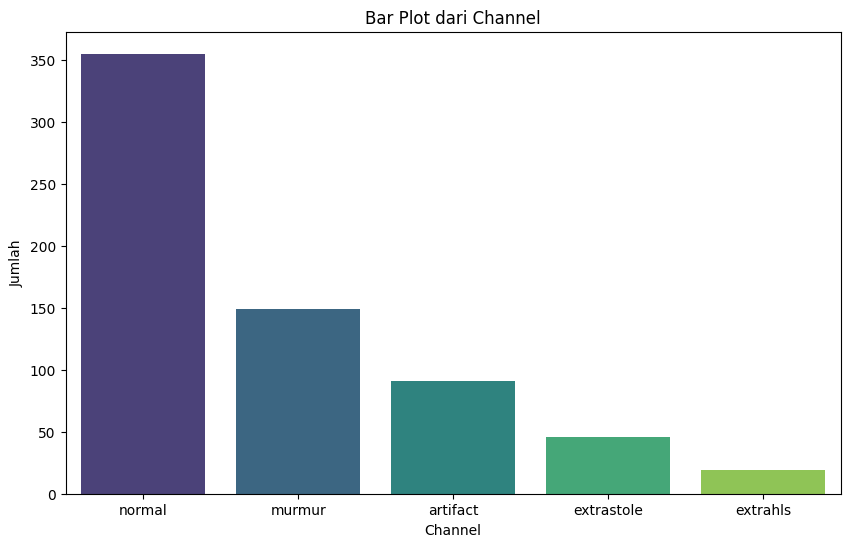

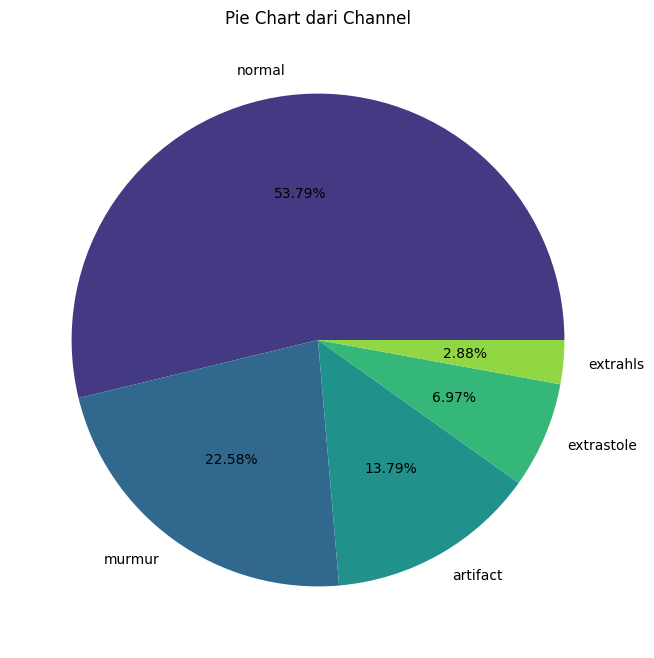

In [10]:
# Membuat bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Bar Plot dari Label')
plt.show()

# Membuat pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_percentages, labels=label_percentages.index, autopct='%1.2f%%', colors=sns.color_palette('viridis', len(label_percentages)))
plt.title('Pie Chart dari Label')
plt.show()

Seperti dijelaskan sebelumnya bahwa data ini tidak seimbang antara data lainnya, oleh karena itu kita wajib melakukan sampling pada kesempatan ini saya menggunakan SMOTE untuk oversampling

In [11]:
sm = SMOTE(random_state=42)
X_resampling, y_resampling = sm.fit_resample(X, y)

/tmp/ipykernel_110951/4203040415.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts_original.keys()), y=list(label_counts_original.values()), palette='viridis')


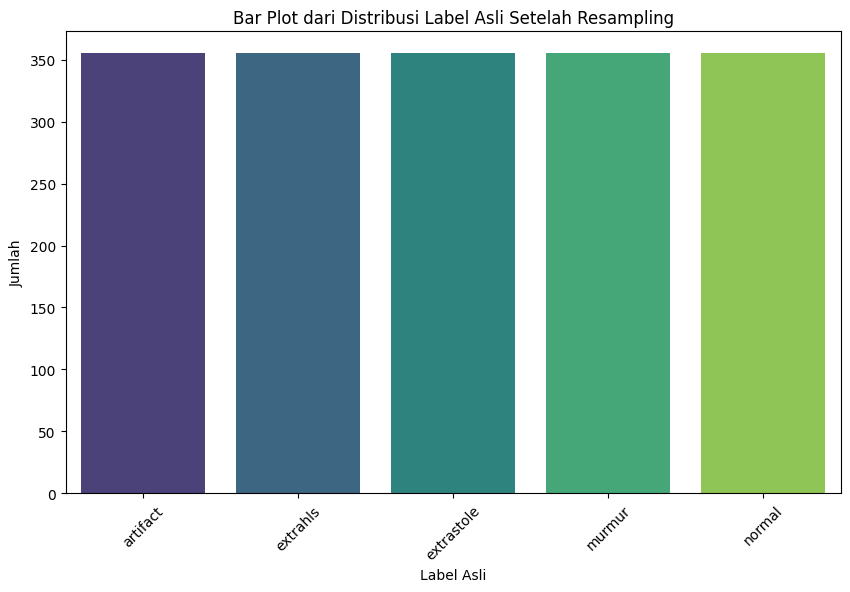

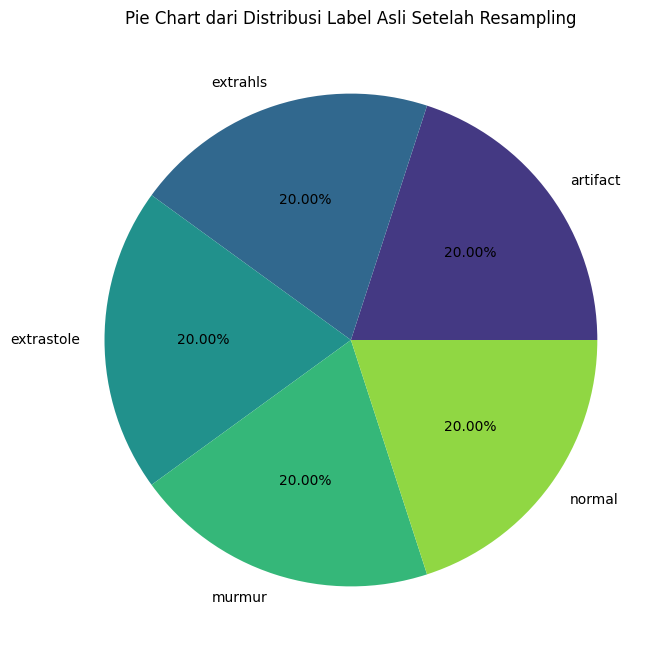

In [12]:
y_original = le.inverse_transform(y_resampling)

# Menghitung distribusi label asli dalam y_resampling
label_counts_original = Counter(y_original)
label_counts_original = dict(sorted(label_counts_original.items()))

# Membuat bar plot untuk y_resampling dengan label asli
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts_original.keys()), y=list(label_counts_original.values()), palette='viridis')
plt.xlabel('Label Asli')
plt.ylabel('Jumlah')
plt.title('Bar Plot dari Distribusi Label Asli Setelah Resampling')
plt.xticks(rotation=45)  # Memutar label jika panjang
plt.show()

# Menghitung persentase masing-masing kelas dalam y_resampling dengan label asli
label_percentages_original = {label: count / len(y_original) * 100 for label, count in label_counts_original.items()}

# Membuat pie chart untuk y_resampling dengan label asli
plt.figure(figsize=(8, 8))
plt.pie(list(label_percentages_original.values()), labels=list(label_percentages_original.keys()), autopct='%1.2f%%', colors=sns.color_palette('viridis', len(label_percentages_original)))
plt.title('Pie Chart dari Distribusi Label Asli Setelah Resampling')
plt.show()

Dengan menggunakan SMOTE, data berhasil seimbang antara data lainnya

In [13]:
X_resampling

Mean mfcc  Std Dev mfcc    Max mfcc  Median mfcc  Variance mfcc  \
0    -28.484547    133.570880  323.493350    -0.662885   17841.178000   
1    -34.966278    178.734620  313.957580     0.100107   31946.064000   
2    -31.556053    163.803880  302.239530    -3.159485   26831.713000   
3    -15.943065    110.068740  326.286740    -5.171048   12115.127000   
4    -15.301639     95.154920  316.893130    -4.762616    9054.460000   
...         ...           ...         ...          ...            ...   
1770  -2.408531    101.641028  196.806905    10.700686   10330.903086   
1771  -5.366493    112.628526  115.482381    11.426089   12685.184214   
1772   0.290806     93.220736  266.992065     5.390110    8690.229781   
1773  -4.985882    102.764350  273.264188    -0.326094   10560.513046   
1774  -1.989956    106.686036  208.844281    13.852887   11381.912075   

      Skewness mfcc  Quartile 1 mfcc  Quartile 3 mfcc   IQR mfcc  MinMax mfcc  \
0         -4.075856        -3.428067         1.804876   5.232943   967.303900   
1         -3.899768        -9.097509         5.817755  14.915264  1231.870700   
2         -3.535077       -14.686425         6.761555  21.447980  1097.702400   
3         -2.291386       -15.684322         3.360450  19.044772   832.514600   
4         -2.769833       -12.728859         2.792716  15.521575   820.383900   
...             ...              ...              ...        ...          ...   
1770      -3.629977         4.070505        22.281520  18.211014   667.169993   
1771      -3.898890         3.173934        31.423225  28.249291   620.120907   
1772      -2.444298        -1.688957        15.216074  16.905031   690.484869   
1773      -2.221562        -8.055692         8.972635  17.028327   724.719098   
1774      -3.847661         5.095890        32.450073  27.354183   685.231628   

      ...   Max rms  Median rms  Variance rms  Skewness rms  Quartile 1 rms  \
0     ...  0.183695    0.000160  1.974953e-04     10.701381        0.000113   
1     ...  0.005230    0.000225  5.114443e-07      3.970705        0.000022   
2     ...  0.004233    0.000227  3.992640e-07      2.560501        0.000157   
3     ...  0.103643    0.010907  1.083698e-04      4.143348        0.007867   
4     ...  0.287264    0.008104  1.039968e-03      4.539478        0.006142   
...   ...       ...         ...           ...           ...             ...   
1770  ...  0.392187    0.093925  1.320225e-02      0.818814        0.021380   
1771  ...  0.315659    0.027198  8.254737e-03      1.706422        0.017307   
1772  ...  0.477788    0.142684  1.592219e-02      0.666956        0.038224   
1773  ...  0.245800    0.060555  2.134650e-03      1.132057        0.040540   
1774  ...  0.451038    0.078804  7.061909e-03      1.945994        0.033209   

      Quartile 3 rms   IQR rms  MinMax rms  Kurtosis rms       Tempo  
0           0.000361  0.000248    0.183622    124.567114  114.843750  
1           0.000412  0.000391    0.005214     18.582176  120.185320  
2           0.000525  0.000367    0.004125      7.743248  123.046875  
3           0.015477  0.007610    0.100495     25.573779  117.453835  
4           0.011690  0.005548    0.286077     24.663706  126.048018  
...              ...       ...         ...           ...         ...  
1770        0.208580  0.187200    0.385562     -0.182755  122.055906  
1771        0.062913  0.045606    0.311138      1.391142  105.712608  
1772        0.232193  0.193969    0.467332     -0.347510  109.836164  
1773        0.090685  0.050145    0.238051      1.626150  126.199462  
1774        0.109436  0.076227    0.442865      3.980548  114.843750  

[1775 rows x 45 columns]

Dan sekarang kita memiliki 1775 data

In [14]:
pca = PCA(n_components=30)
pca.fit(X_resampling)

# Ambil nilai bobot dari komponen utama
components = pca.components_

# Buat DataFrame untuk menyimpan bobot fitur
weights_df = pd.DataFrame(components, columns=X_resampling.columns)

# Urutkan bobot fitur secara absolut untuk setiap komponen utama
sorted_weights = weights_df.abs().apply(lambda x: x.sort_values(ascending=False), axis=1)

# Ambil 30 fitur dengan bobot tertinggi untuk setiap komponen utama
selected_features = sorted_weights.columns[:30]

print("Fitur yang dipilih oleh PCA:")
print(selected_features)
print(len(selected_features))

Fitur yang dipilih oleh PCA:
Index(['IQR chroma_cqt', 'IQR chroma_stft', 'IQR mfcc', 'IQR rms',
       'Kurtosis chroma_cqt', 'Kurtosis chroma_stft', 'Kurtosis mfcc',
       'Kurtosis rms', 'Max chroma_cqt', 'Max chroma_stft', 'Max mfcc',
       'Max rms', 'Mean chroma_cqt', 'Mean chroma_stft', 'Mean mfcc',
       'Mean rms', 'Median chroma_cqt', 'Median chroma_stft', 'Median mfcc',
       'Median rms', 'MinMax chroma_cqt', 'MinMax chroma_stft', 'MinMax mfcc',
       'MinMax rms', 'Quartile 1 chroma_cqt', 'Quartile 1 chroma_stft',
       'Quartile 1 mfcc', 'Quartile 1 rms', 'Quartile 3 chroma_cqt',
       'Quartile 3 chroma_stft'],
      dtype='object')
30


Menggunakan feature selection dengan PCA sebanyak 30 fitur saja yang akan digunakan agar sumber daya yang digunakan lebih efisien dan menghindari overfitting

In [15]:
X_resampling_pca = pca.transform(X_resampling)
X_resampling_pca = pd.DataFrame(data=X_resampling_pca, index=X_resampling.index)
X_resampling_pca

0           1          2          3          4          5   \
0      5200.748599   95.762462  34.921884 -51.849076  99.944496   2.180558   
1     19307.933670   27.079036  44.793402 -12.415068 -10.319987   1.982839   
2     14191.820283    9.534093  42.406628  -4.435848 -13.757193  -7.790708   
3      -527.027183   93.049011  41.854155 -15.749202  12.077862 -13.044860   
4     -3587.186450  144.719320  13.420423  -5.228383  15.952291 -10.425190   
...            ...         ...        ...        ...        ...        ...   
1770  -2314.733745  -72.563700 -28.870299   7.498294  -0.124712   8.919295   
1771     37.805693 -198.194467 -68.570818  -1.306888   0.228184   5.700627   
1772  -3954.416632   11.058125  12.070408  -9.809299  -7.827764   3.235090   
1773  -2083.798379    5.801740  22.385440   4.063399  -1.892381  -6.280774   
1774  -1263.577346  -74.644906 -17.205133  -1.439580  -1.038056  16.166585   

             6         7         8         9   ...        20        21  \
0     -5.761002  5.741246  0.260309  1.737491  ...  0.077513  0.021854   
1     -1.502088 -6.339811 -7.486660  1.505306  ...  0.036114 -0.061207   
2      4.268187 -0.989895 -4.034278  0.836410  ... -0.041155 -0.003637   
3      2.006819  3.230445  1.715147  1.776552  ... -0.020901  0.016448   
4     -4.346294  2.863333 -1.814611  1.107448  ... -0.051428  0.002679   
...         ...       ...       ...       ...  ...       ...       ...   
1770   0.496901 -0.483813 -1.263478 -0.572316  ...  0.105996  0.061901   
1771  12.974608  1.901615 -1.987175  0.308990  ...  0.004734 -0.037116   
1772   0.141448 -3.061687  0.616962 -0.102071  ...  0.064546  0.029317   
1773  -0.827189 -2.281117  3.607870  0.398408  ... -0.034707 -0.017639   
1774  12.927724  3.693562 -4.426530 -0.196411  ... -0.019053 -0.043335   

            22        23        24        25        26        27        28  \
0    -0.048673  0.013058 -0.065805 -0.006231 -0.006075  0.000048  0.013558   
1    -0.025769 -0.006230 -0.004788 -0.009876 -0.005198  0.008575 -0.005570   
2    -0.007659  0.002654 -0.002167  0.005293  0.010687  0.004971 -0.005421   
3     0.008419 -0.041824 -0.007600  0.001153 -0.007033  0.006312  0.004356   
4     0.005101 -0.012782  0.021970  0.010247  0.006020  0.005455 -0.010924   
...        ...       ...       ...       ...       ...       ...       ...   
1770  0.014046 -0.026076  0.009370 -0.012374  0.009385 -0.013480 -0.012324   
1771 -0.022741  0.042372 -0.000900 -0.025744  0.010485  0.009483  0.009880   
1772  0.006879 -0.002948  0.007951  0.006675  0.015362  0.009310 -0.000625   
1773  0.007680 -0.010283  0.001666 -0.010409 -0.000302 -0.004939 -0.004910   
1774 -0.012172  0.014459 -0.041891  0.015404  0.021030  0.004715 -0.014028   

            29  
0    -0.003060  
1     0.004910  
2     0.003001  
3    -0.000249  
4    -0.001505  
...        ...  
1770 -0.001968  
1771 -0.001178  
1772  0.004503  
1773 -0.000647  
1774 -0.007596  

[1775 rows x 30 columns]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_resampling_pca, y_resampling, test_size = 0.2, random_state = 42)

Split data menjadi train dan test

In [17]:
#proses standarisasi fitur
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print(type(X_train))
X_train = pd.DataFrame(X_train, columns=X_resampling_pca.columns)

<class 'numpy.ndarray'>


In [18]:
X_train.head()

0         1         2         3         4         5         6   \
0  0.437513 -0.504404 -0.433160  0.968702  1.094814 -0.408205 -0.346279   
1 -0.706924 -0.710253 -0.198436  0.900312  0.549823  0.497295  0.294604   
2 -0.142218  2.042092  0.242989 -1.874825 -1.031153  0.076962 -2.014935   
3 -0.631242 -0.524999  0.145972  3.341173  1.427131  1.090401 -0.558032   
4  1.352859  2.344874 -1.454348  0.315030  1.546653  0.210551  0.774755   

         7         8         9   ...        20        21        22        23  \
0  1.385228 -0.167154  0.016370  ...  0.295715  0.103076  0.601183 -0.046777   
1  0.115016 -1.070690  0.107069  ...  0.234120  0.523006  0.681479 -1.483054   
2  1.375448 -0.294410 -1.154302  ... -2.474118  0.415843  1.011058 -0.506909   
3 -0.048811 -0.954974 -0.068117  ...  0.446169 -0.523752 -1.234948  0.426073   
4 -0.291317  1.143804  1.664860  ...  0.082093  0.786483 -0.731955 -0.843901   

         24        25        26        27        28        29  
0  0.425048  0.310190 -0.221942 -0.362965  0.083623  0.730156  
1 -0.690844  1.296954 -0.533109  0.047417 -0.080794 -0.189110  
2  0.567786  0.861851 -0.510234 -0.110603 -1.290000 -0.160077  
3 -1.643866  1.286865 -0.596152  0.936293  1.531355 -0.986296  
4  0.054262 -0.203377  0.389296 -0.775601  1.113423 -0.809086  

[5 rows x 30 columns]

In [19]:
X_train.describe().round(4)

0          1          2          3          4          5   \
count  1420.0000  1420.0000  1420.0000  1420.0000  1420.0000  1420.0000   
mean     -0.0000    -0.0000    -0.0000     0.0000    -0.0000     0.0000   
std       1.0004     1.0004     1.0004     1.0004     1.0004     1.0004   
min      -1.5564    -2.7517    -3.4097    -4.2118    -2.0560    -6.9714   
25%      -0.6684    -0.5511    -0.4258    -0.4597    -0.4389    -0.3323   
50%      -0.2229    -0.2304     0.1671     0.0245    -0.1583     0.1289   
75%       0.4321     0.3393     0.5974     0.5344     0.2730     0.5293   
max       5.7424     3.7433     3.1430     4.8601    13.4303     2.8787   

              6          7          8          9   ...         20         21  \
count  1420.0000  1420.0000  1420.0000  1420.0000  ...  1420.0000  1420.0000   
mean     -0.0000    -0.0000     0.0000    -0.0000  ...    -0.0000    -0.0000   
std       1.0004     1.0004     1.0004     1.0004  ...     1.0004     1.0004   
min      -4.0883    -8.7877    -6.3543   -13.1773  ...    -5.3258    -6.9095   
25%      -0.5325    -0.4932    -0.5515    -0.3667  ...    -0.4448    -0.3391   
50%      -0.1687     0.0429     0.0424     0.0135  ...    -0.0167    -0.0306   
75%       0.3544     0.6134     0.7519     0.4173  ...     0.5252     0.3083   
max       6.9124     2.8134     3.8830     3.7511  ...     5.1139     8.3163   

              22         23         24         25         26         27  \
count  1420.0000  1420.0000  1420.0000  1420.0000  1420.0000  1420.0000   
mean      0.0000     0.0000    -0.0000     0.0000     0.0000     0.0000   
std       1.0004     1.0004     1.0004     1.0004     1.0004     1.0004   
min      -5.6671    -6.5501    -3.6511    -4.9615    -8.7210    -7.5996   
25%      -0.6473    -0.5420    -0.4506    -0.4829    -0.3341    -0.4382   
50%       0.0257     0.0161     0.0152     0.0165    -0.0071    -0.0455   
75%       0.6949     0.5768     0.4253     0.4977     0.3748     0.4205   
max       3.6197     5.6940    11.2972     7.4277     7.4117     4.9920   

              28         29  
count  1420.0000  1420.0000  
mean     -0.0000     0.0000  
std       1.0004     1.0004  
min      -6.6504    -6.6312  
25%      -0.4438    -0.3590  
50%      -0.0084    -0.0270  
75%       0.4950     0.3223  
max       5.6827    13.6669  

[8 rows x 30 columns]

Standarisasi fitur pada data training

In [20]:
X_test = scaler.transform(X_test)
print(type(X_test))
X_test = pd.DataFrame(X_test, columns=X_resampling_pca.columns)

<class 'numpy.ndarray'>


In [21]:
X_test.head()

0         1         2         3         4         5         6   \
0  0.005534 -1.146208 -0.881708  0.156231 -0.157416  2.844731  1.266750   
1  0.605133 -0.491302 -0.767043  0.200274  0.407859 -0.397536 -0.431961   
2  2.866410 -0.171201  1.169069 -0.448405 -0.776168 -0.254687 -1.040475   
3  0.442381 -0.840408  0.545128  0.605935 -0.159551 -0.008142  1.403874   
4 -1.120809  0.105121  0.939657  2.526945  0.803757  0.425481 -0.274433   

         7         8         9   ...        20        21        22        23  \
0  1.004402 -1.698896 -0.624167  ...  0.924960 -1.668424  0.644097 -0.180954   
1  1.424208 -0.230401 -0.295122  ... -0.007198  0.197196  1.073559  0.039154   
2 -0.377985 -2.090842 -0.294512  ...  0.269459  0.091549 -0.570971 -1.234186   
3 -0.127446  1.453871  1.059875  ...  0.342575  0.210049 -0.093971 -1.919361   
4 -1.453968 -0.764730  0.294853  ...  0.719732  1.117659 -0.272871  0.479784   

         24        25        26        27        28        29  
0 -2.490111  0.122898  0.090447 -0.592442 -0.588416 -0.083033  
1  0.512386  0.169774 -0.102213 -0.218028  0.153813  0.802831  
2  0.523906 -0.314025  0.476130  0.086762 -0.506559  0.444406  
3 -0.686457 -0.335398 -0.119200 -0.487491 -0.070700  0.308098  
4 -0.014344 -1.113398 -2.212936  0.628403  0.813384 -0.237177  

[5 rows x 30 columns]

In [22]:
X_test.describe().round(4)

0         1         2         3         4         5         6   \
count  355.0000  355.0000  355.0000  355.0000  355.0000  355.0000  355.0000   
mean    -0.0309   -0.1230    0.0247   -0.0304   -0.0271   -0.0027   -0.0671   
std      1.0098    0.8888    0.9644    0.9373    1.0667    0.9081    0.8818   
min     -1.5502   -2.3496   -2.9915   -3.8563   -1.6272   -6.0959   -2.7380   
25%     -0.7215   -0.5835   -0.4483   -0.5280   -0.4825   -0.3039   -0.5497   
50%     -0.2658   -0.3146    0.0728    0.0897   -0.1741    0.1166   -0.2003   
75%      0.3762    0.1807    0.5875    0.5307    0.1878    0.4463    0.3257   
max      5.5641    2.9636    3.0770    2.5269    9.1703    2.8447    3.2418   

             7         8         9   ...        20        21        22  \
count  355.0000  355.0000  355.0000  ...  355.0000  355.0000  355.0000   
mean    -0.0342   -0.0466    0.0073  ...    0.0854    0.0675   -0.0224   
std      0.9268    0.9839    0.7833  ...    0.9955    0.9362    1.0276   
min     -5.3391   -6.2095   -3.7593  ...   -3.1139   -5.0804   -5.3555   
25%     -0.4855   -0.5595   -0.4134  ...   -0.4078   -0.3030   -0.6252   
50%     -0.0371   -0.0519   -0.0322  ...    0.0430    0.0174    0.0088   
75%      0.6059    0.7080    0.3490  ...    0.5578    0.3732    0.6924   
max      2.3058    2.1162    3.8239  ...    4.3931    6.5264    2.8094   

             23        24        25        26        27        28        29  
count  355.0000  355.0000  355.0000  355.0000  355.0000  355.0000  355.0000  
mean     0.0625   -0.0783   -0.0517   -0.0150   -0.0142    0.0702   -0.0602  
std      1.1354    0.9809    1.1148    1.0433    1.0912    1.0789    0.9254  
min     -4.5604   -3.9143   -4.9613   -4.2973   -5.9361   -4.9100   -6.2577  
25%     -0.5634   -0.5018   -0.4436   -0.3873   -0.4615   -0.4250   -0.3818  
50%      0.0684   -0.0435   -0.0876   -0.0604   -0.0337    0.0082   -0.0104  
75%      0.6375    0.3648    0.3979    0.3544    0.5032    0.5043    0.2955  
max      7.8304    6.0926    7.0636    6.5862    4.0259    9.6041    5.6410  

[8 rows x 30 columns]

Standarisasi fitur pada data test dari standarisasi yang sudah fit pada data training

# Model Development

## Random Forest

Menggunakan Algoritma Random Forest

In [23]:
def grid_search_rf(X, y, param_grid=None, n_jobs=-1):
    # Parameter grid untuk GridSearchCV
    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [16, 32, 64, 128, 256],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    
    # Inisialisasi Random Forest
    rf = RandomForestClassifier(random_state=42)
    
    # Inisialisasi GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=n_jobs)
    
    # Fit GridSearchCV pada seluruh data
    grid_search.fit(X, y)
    
    # Menampilkan parameter terbaik dari GridSearchCV
    print(f'Best Parameters: {grid_search.best_params_}')
    
    # Menampilkan semua parameter yang dicoba
    print('Grid Search Parameters:')
    for i in range(len(grid_search.cv_results_['params'])):
        print(f"Params: {grid_search.cv_results_['params'][i]}, Mean Test Score: {grid_search.cv_results_['mean_test_score'][i] * 100:.2f}%")

In [24]:
grid_search_rf(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/home/macreai/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 32, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Grid Search Parameters:
Params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, Mean Test Score: 90.07%
Params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, Mean Test Score: 90.56%
Params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}, Mean Test Score: 89.58%
Params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}, Mean Test Score: 89.93%
Params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}, Mean Test Score: 88.94%
Params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}, Mean Test Score: 89.23%
Params: {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, Mean Test Score: 90.28%
Params: {'max_depth': 16, 'min_samples

Dengan menggunakan grid search untuk parameter tuning, didapatkan 'max_depth': 32, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200 dengan skor 90.92% Akurasi

In [25]:
def k_fold_cross_validation_rf(X, y, k=7, n_estimators=200, max_depth=32, min_samples_leaf=1, min_samples_split=2):
    # Inisialisasi KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Daftar untuk menyimpan hasil
    accuracies = []
    sensitivities = []
    precisions = []
    f1_scores = []
    confusion_matrices = []
    models = []
    
    # Loop untuk setiap fold
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        print(f'Fold {fold}')
        
        # Split data menjadi data latih dan data tes
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Inisialisasi dan latih Random Forest
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, random_state=42)
        rf.fit(X_train, y_train)
        
        # Prediksi
        y_pred = rf.predict(X_test)
        
        # Hitung metrik
        acc = accuracy_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred, average='macro')  # Sensitivitas untuk multiclass
        precision = precision_score(y_test, y_pred, average='macro')  # Precision untuk multiclass
        f1 = f1_score(y_test, y_pred, average='macro')  # F1 Score untuk multiclass
        
        # Simpan hasil
        accuracies.append(acc * 100)  # Convert to percentage
        sensitivities.append(sensitivity * 100)
        precisions.append(precision * 100)
        f1_scores.append(f1 * 100)
        confusion_matrices.append(confusion_matrix(y_test, y_pred))
        models.append(rf)

        # Tampilkan confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for Fold {fold}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    # Menampilkan hasil
    print("Akurasi setiap fold (%):", ["{:.2f}".format(acc) for acc in accuracies])
    print("Sensitivitas setiap fold (%):", ["{:.2f}".format(sens) for sens in sensitivities])
    print("Spesifisitas setiap fold (%):", ["{:.2f}".format(spec) for spec in precisions])
    print("F1 Score setiap fold (%):", ["{:.2f}".format(f1) for f1 in f1_scores])

    return models


Fold 1


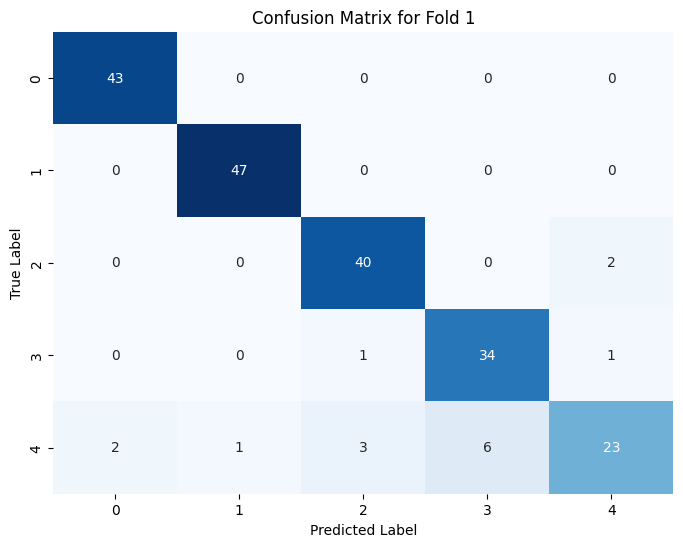

Fold 2


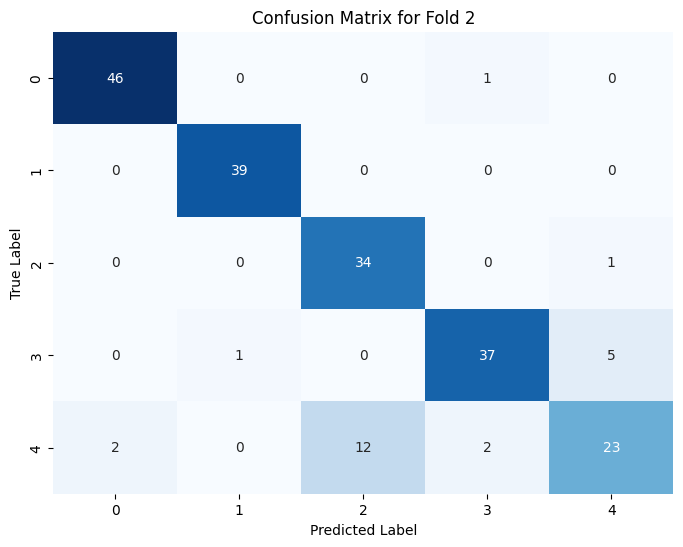

Fold 3


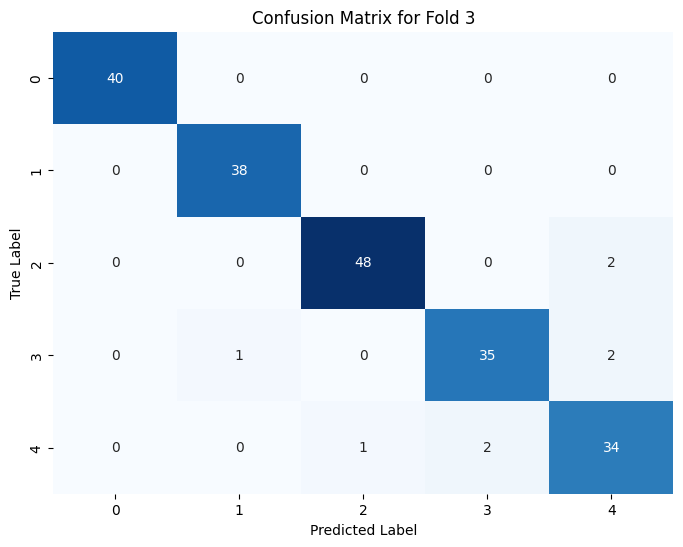

Fold 4


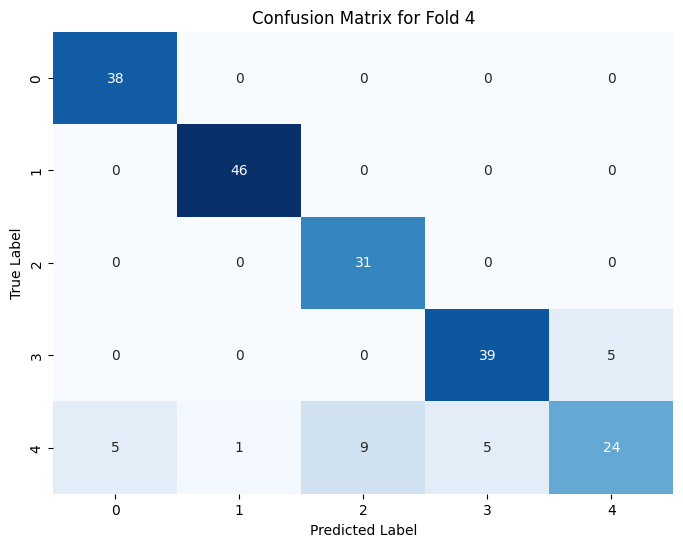

Fold 5


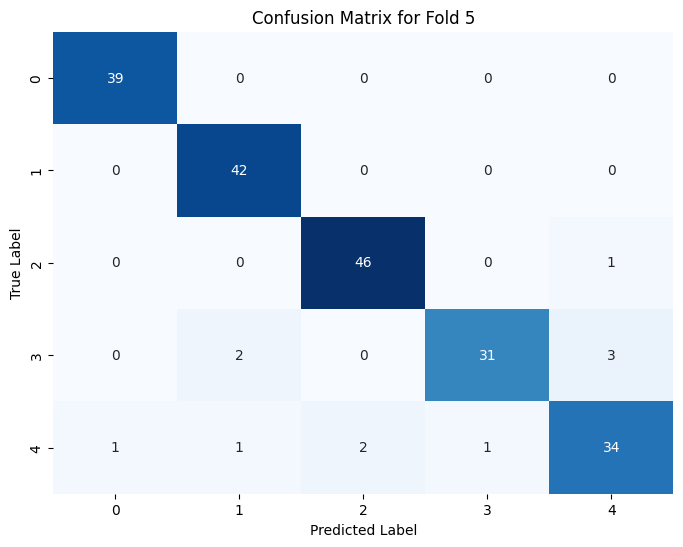

Fold 6


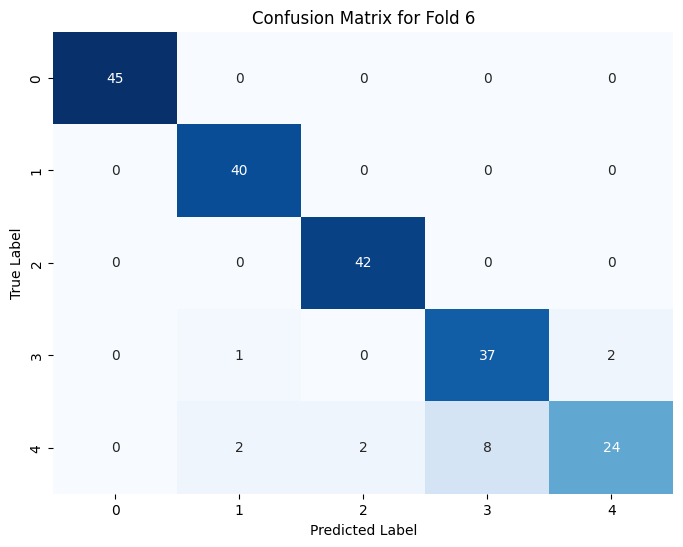

Fold 7


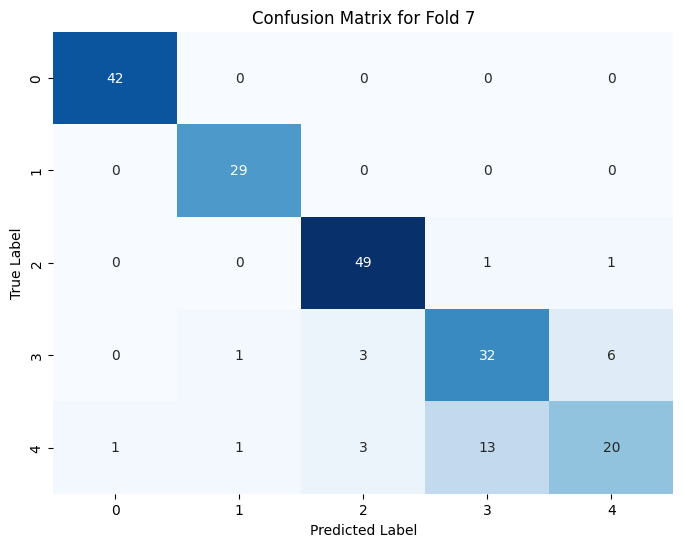

Akurasi setiap fold (%): ['92.12', '88.18', '96.06', '87.68', '94.58', '92.61', '85.15']
Sensitivitas setiap fold (%): ['91.08', '88.01', '96.00', '88.64', '94.23', '91.83', '84.98']
Spesifisitas setiap fold (%): ['91.57', '87.81', '95.89', '87.03', '94.60', '92.60', '84.79']
F1 Score setiap fold (%): ['90.92', '87.27', '95.93', '86.89', '94.32', '91.71', '84.44']


In [26]:
models_rf = k_fold_cross_validation_rf(X_train, y_train)

Menggunakan K-Fold Cross Validation sebanyak 7 dengan waktu komputasi 11.7s dan didapatkan yang terbaik yaitu Fold ke-3 dengan skor Akurasi sebesar 96.06%, Sensitivitas 96%, Spesifisitas 95.89%, dan F1-Score 95.93% pada data training

Berikut adalah rata-rata untuk masing-masing metrik:

- **Rata-rata Akurasi:** 90.91%
- **Rata-rata Sensitivitas:** 90.68%
- **Rata-rata Spesifisitas:** 90.61%
- **Rata-rata F1 Score:** 90.21%

====Fold 1====
Accuracy:  0.9154929577464789
Sensitivity:  0.9267273610821855
Precision:  0.915810823446167
F1 Score:  0.9186332848605996


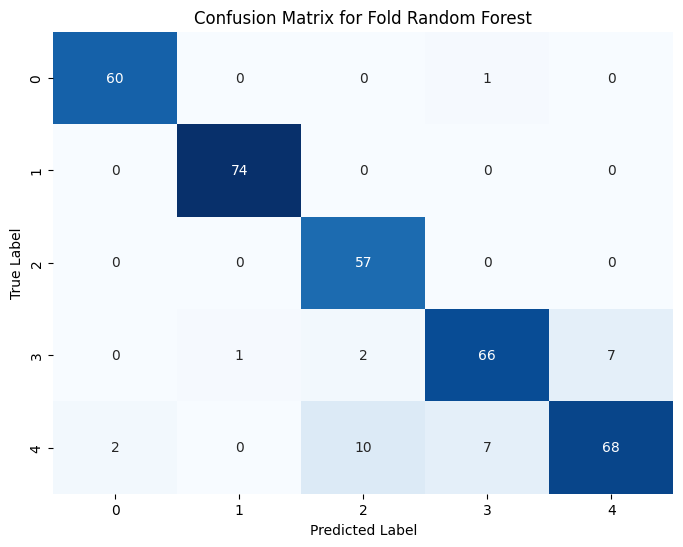

====Fold 2====
Accuracy:  0.9070422535211268
Sensitivity:  0.920810647307925
Precision:  0.9085301772906723
F1 Score:  0.9100935447860679


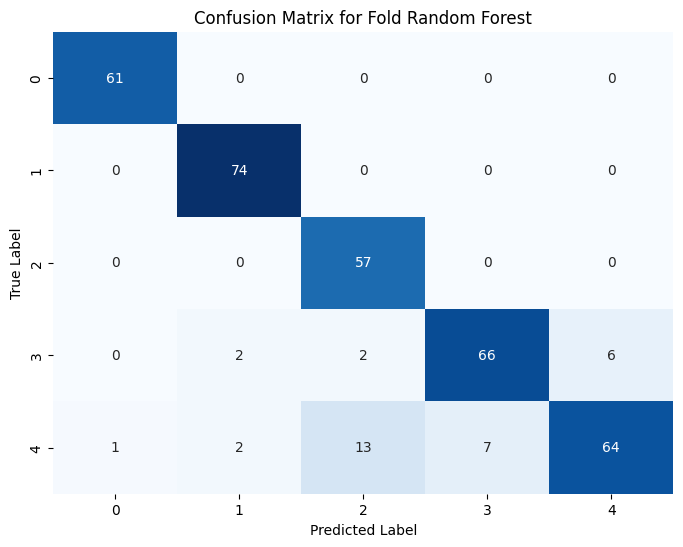

====Fold 3====
Accuracy:  0.9042253521126761
Sensitivity:  0.9185117967332124
Precision:  0.9058536524403433
F1 Score:  0.9090295593878182


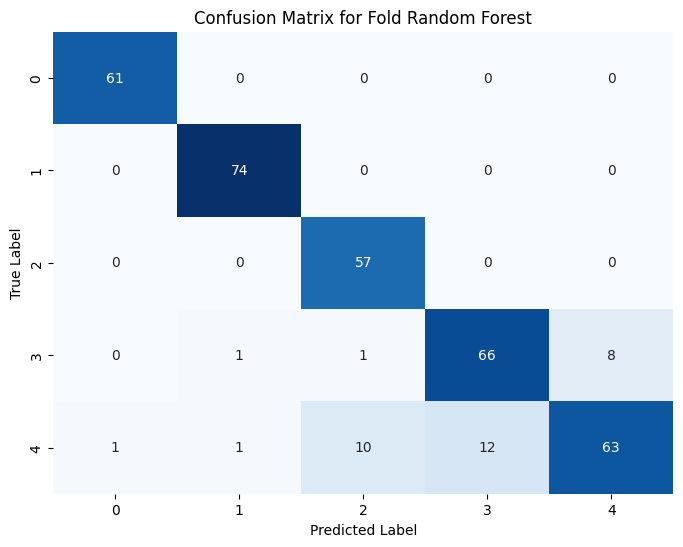

====Fold 4====
Accuracy:  0.9014084507042254
Sensitivity:  0.9155474894131881
Precision:  0.9020438269996776
F1 Score:  0.9063442987766578


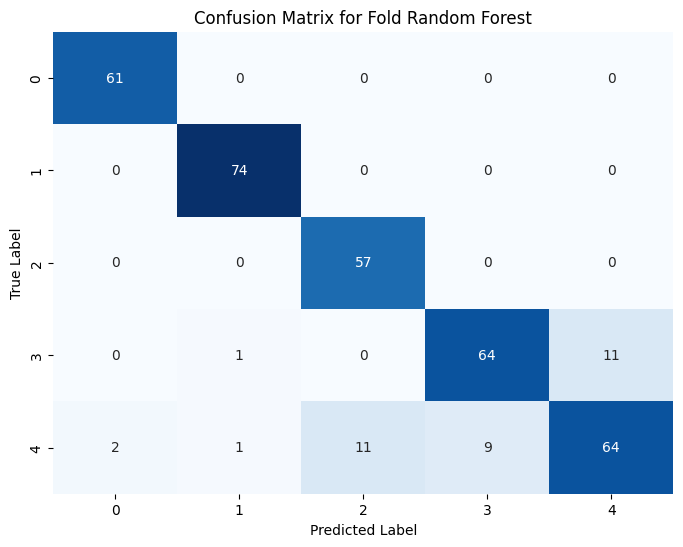

====Fold 5====
Accuracy:  0.9014084507042254
Sensitivity:  0.9132486388384755
Precision:  0.9023368667101543
F1 Score:  0.9058032827223818


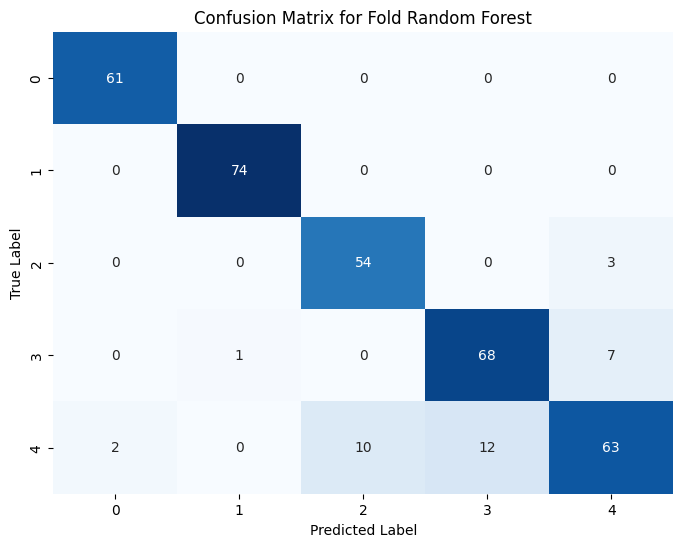

====Fold 6====
Accuracy:  0.9014084507042254
Sensitivity:  0.9152514553767119
Precision:  0.9041811363593821
F1 Score:  0.9052024203860889


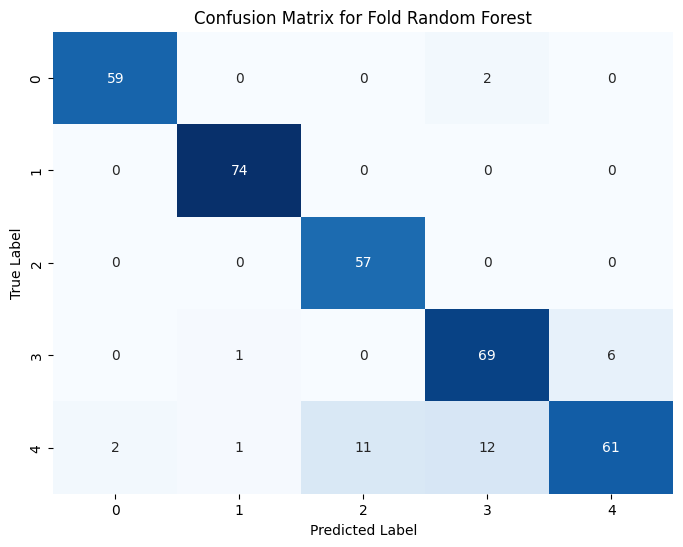

====Fold 7====
Accuracy:  0.9070422535211268
Sensitivity:  0.9214761040532367
Precision:  0.9088545807386389
F1 Score:  0.9119086961339227


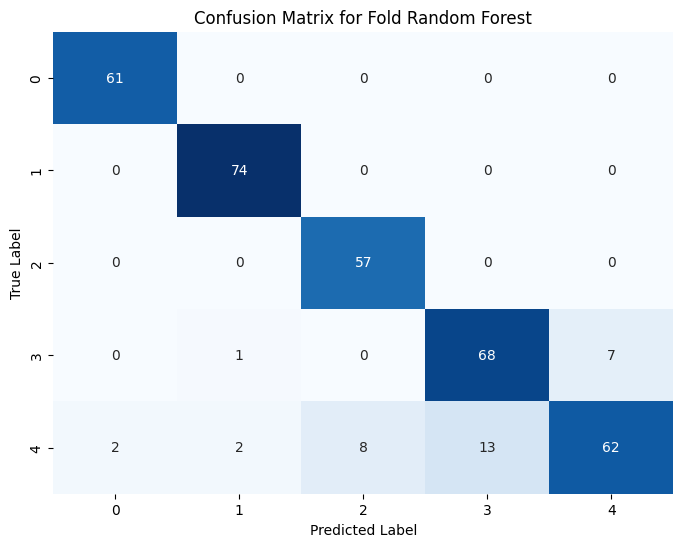

In [27]:
for i in range(len(models_rf)):
    print(f'====Fold {i+1}====')
    # Prediksi
    y_pred = models_rf[i].predict(X_test)

    # Hitung metrik
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Sensitivity: ', recall_score(y_test, y_pred, average='macro'))  # Sensitivitas untuk multiclass
    print('Precision: ', precision_score(y_test, y_pred, average='macro'))  # Precision untuk multiclass
    print('F1 Score: ', f1_score(y_test, y_pred, average='macro'))  # F1 Score untuk multiclass

    # Tampilkan confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix for Fold Random Forest')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Selanjutnya kita akan memeriksa semua Fold terhadap data yang belum dilihatnya, Fold pertama meraih nilai performa paling tinggi yaitu:

Accuracy:  91.55%
Sensitivity:  92.67%
Precision:  91.58%
F1 Score:  91.86%

Berikut adalah rata-rata dari setiap metrik dalam fold:
<br>
- Accuracy: 91.05%
- Sensitivity: 92.01%
- Precision: 92.10%
- F1 Score: 92.00%

In [28]:
#Fungsi untuk plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [29]:
def create_lstm_model(input_shape, num_classes):
    model = models.Sequential()
    
    # LSTM Layer
    model.add(layers.LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(layers.LSTM(64))
    
    # Fully Connected Layer
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

Membuat model Deep Learning dengan arsitekur LSTM

In [30]:
model = KerasClassifier(build_fn=create_lstm_model, verbose=0, input_shape=(40, 1), num_classes=5)

param_grid = {
    'batch_size': [64, 128, 256],
    'epochs': [50, 100, 150, 200]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']

epochs = [param['epochs'] for param in params]

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

/home/macreai/.local/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
I0000 00:00:1724726562.511610  110951 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 09:42:42.552176: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/macreai/.local/lib/python3.10/site-packages/keras/sr

/home/macreai/.local/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/macreai/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


/home/macreai/.local/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/macreai/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/macreai/.local/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/macreai/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Inp

Best: 0.819013 using {'batch_size': 64, 'epochs': 200}
0.750702 with: {'batch_size': 64, 'epochs': 50}
0.785924 with: {'batch_size': 64, 'epochs': 100}
0.803512 with: {'batch_size': 64, 'epochs': 150}
0.819013 with: {'batch_size': 64, 'epochs': 200}
0.738722 with: {'batch_size': 128, 'epochs': 50}
0.780991 with: {'batch_size': 128, 'epochs': 100}
0.775350 with: {'batch_size': 128, 'epochs': 150}
0.790845 with: {'batch_size': 128, 'epochs': 200}
0.734492 with: {'batch_size': 256, 'epochs': 50}
0.755634 with: {'batch_size': 256, 'epochs': 100}
0.769728 with: {'batch_size': 256, 'epochs': 150}
0.784496 with: {'batch_size': 256, 'epochs': 200}


Melakukan parameter tuning dengan Grid Search, didapatkan {'batch_size': 64, 'epochs': 200} dengan skor 81.9% Akurasi

In [34]:
# Fungsi untuk melakukan K-fold cross-validation
def k_fold_cross_validation_lstm(X, y, k=7, epochs=200, batch_size=64):
    # Inisialisasi KFold
    skf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Daftar untuk menyimpan model pada setiap fold dan akurasi, sensitivitas, spesifisitas, F1 score
    models = []
    accuracies = []
    sensitivities = []
    precisions = []
    f1_scores = []
    
    # Loop melalui setiap fold
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f'Fold {fold}')
        
        # Split data menjadi data latih dan data validasi
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Inisialisasi model
        model = create_lstm_model(input_shape=(40, 1), num_classes=5)
        
        # Latih model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2)
        
        plot_training_history(history)
        
        # Evaluasi model pada data validasi
        y_pred = model.predict(X_val)
        y_pred_classes = y_pred.argmax(axis=-1)
        
        # Hitung metrik
        accuracy = accuracy_score(y_val, y_pred_classes)
        cm = confusion_matrix(y_val, y_pred_classes)
        sensitivity = recall_score(y_val, y_pred_classes, average='macro')
        precision = precision_score(y_val, y_pred_classes, average='macro')
        f1 = f1_score(y_val, y_pred_classes, average='macro')
        
        # Tambahkan metrik ke dalam daftar
        accuracies.append(accuracy * 100)
        sensitivities.append(sensitivity * 100)
        precisions.append(precision * 100)
        f1_scores.append(f1 * 100)
        
        # Tambahkan model ke dalam daftar
        models.append(model)
        
        print(f'Validation Accuracy: {accuracy * 100:.2f}%')
        print()
    
    # Menampilkan hasil
    print("Akurasi setiap fold (%):", ["{:.2f}".format(acc) for acc in accuracies])
    print("Sensitivitas setiap fold (%):", ["{:.2f}".format(sens) for sens in sensitivities])
    print("Spesifisitas setiap fold (%):", ["{:.2f}".format(spec) for spec in precisions])
    print("F1 Score setiap fold (%):", ["{:.2f}".format(f1) for f1 in f1_scores])
    
    return models


Fold 1


/home/macreai/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
20/20 - 6s - 283ms/step - accuracy: 0.2761 - loss: 1.5889 - val_accuracy: 0.3350 - val_loss: 1.5396
Epoch 2/200
20/20 - 1s - 38ms/step - accuracy: 0.3624 - loss: 1.4688 - val_accuracy: 0.4089 - val_loss: 1.3569
Epoch 3/200
20/20 - 1s - 38ms/step - accuracy: 0.4232 - loss: 1.3611 - val_accuracy: 0.4335 - val_loss: 1.2735
Epoch 4/200
20/20 - 1s - 25ms/step - accuracy: 0.4626 - loss: 1.2672 - val_accuracy: 0.4631 - val_loss: 1.2050
Epoch 5/200
20/20 - 1s - 26ms/step - accuracy: 0.5012 - loss: 1.1964 - val_accuracy: 0.5123 - val_loss: 1.1626
Epoch 6/200
20/20 - 1s - 33ms/step - accuracy: 0.5341 - loss: 1.1208 - val_accuracy: 0.5961 - val_loss: 1.0695
Epoch 7/200
20/20 - 1s - 31ms/step - accuracy: 0.5711 - loss: 1.0708 - val_accuracy: 0.6059 - val_loss: 1.0619
Epoch 8/200
20/20 - 1s - 26ms/step - accuracy: 0.5883 - loss: 1.0266 - val_accuracy: 0.6847 - val_loss: 0.8915
Epoch 9/200
20/20 - 1s - 29ms/step - accuracy: 0.6179 - loss: 0.9933 - val_accuracy: 0.6897 - val_loss: 0.8502


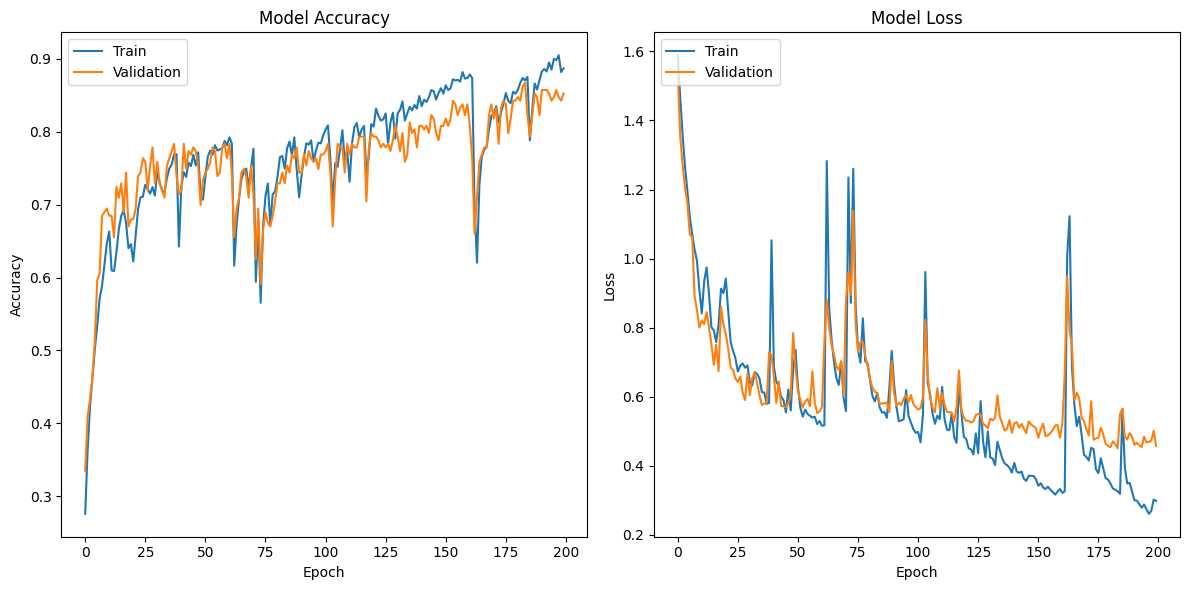

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step
Validation Accuracy: 85.22%

Fold 2


/home/macreai/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
20/20 - 7s - 347ms/step - accuracy: 0.2925 - loss: 1.5895 - val_accuracy: 0.3547 - val_loss: 1.5206
Epoch 2/200
20/20 - 1s - 35ms/step - accuracy: 0.3846 - loss: 1.4796 - val_accuracy: 0.5567 - val_loss: 1.3156
Epoch 3/200
20/20 - 1s - 30ms/step - accuracy: 0.4519 - loss: 1.3654 - val_accuracy: 0.5369 - val_loss: 1.2194
Epoch 4/200
20/20 - 1s - 43ms/step - accuracy: 0.5366 - loss: 1.2350 - val_accuracy: 0.5961 - val_loss: 1.0806
Epoch 5/200
20/20 - 1s - 45ms/step - accuracy: 0.5727 - loss: 1.1332 - val_accuracy: 0.5123 - val_loss: 1.1168
Epoch 6/200
20/20 - 1s - 38ms/step - accuracy: 0.6072 - loss: 1.0557 - val_accuracy: 0.5764 - val_loss: 1.0935
Epoch 7/200
20/20 - 1s - 43ms/step - accuracy: 0.6261 - loss: 1.0092 - val_accuracy: 0.6305 - val_loss: 0.9444
Epoch 8/200
20/20 - 1s - 31ms/step - accuracy: 0.5990 - loss: 1.0295 - val_accuracy: 0.6453 - val_loss: 0.8662
Epoch 9/200
20/20 - 1s - 29ms/step - accuracy: 0.6294 - loss: 0.9641 - val_accuracy: 0.6650 - val_loss: 0.8411


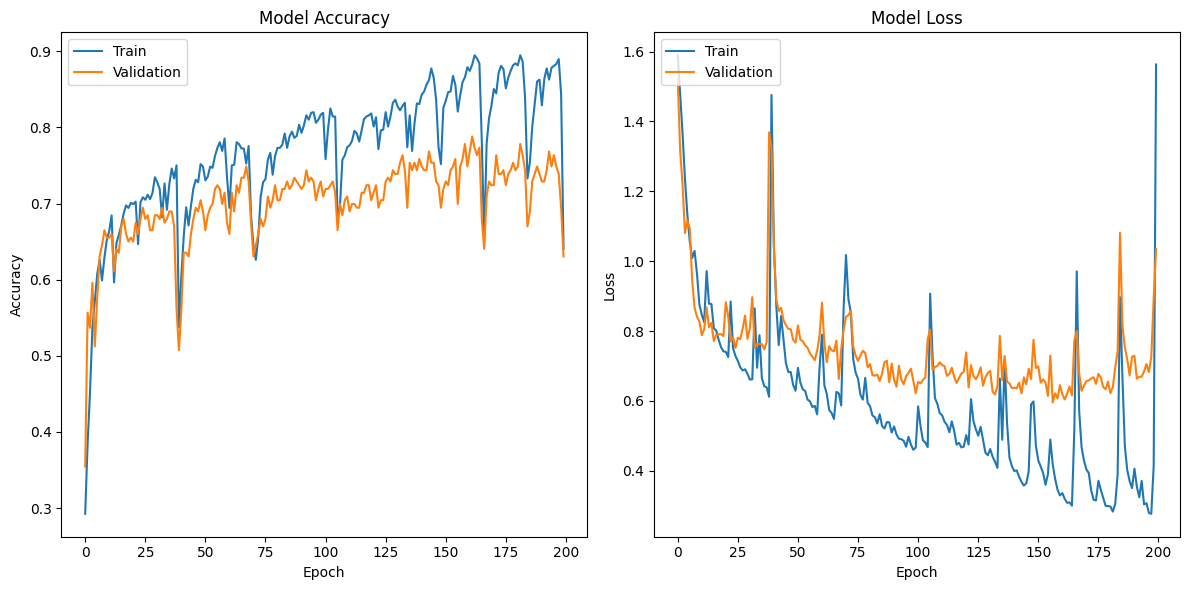

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Validation Accuracy: 63.05%

Fold 3
Epoch 1/200


/home/macreai/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 5s - 253ms/step - accuracy: 0.2523 - loss: 1.5821 - val_accuracy: 0.3153 - val_loss: 1.5372
Epoch 2/200
20/20 - 1s - 28ms/step - accuracy: 0.3525 - loss: 1.5006 - val_accuracy: 0.4138 - val_loss: 1.4008
Epoch 3/200
20/20 - 1s - 27ms/step - accuracy: 0.4495 - loss: 1.3309 - val_accuracy: 0.4581 - val_loss: 1.2794
Epoch 4/200
20/20 - 1s - 27ms/step - accuracy: 0.4864 - loss: 1.2856 - val_accuracy: 0.5320 - val_loss: 1.2029
Epoch 5/200
20/20 - 1s - 27ms/step - accuracy: 0.5283 - loss: 1.1937 - val_accuracy: 0.5813 - val_loss: 1.0869
Epoch 6/200
20/20 - 1s - 29ms/step - accuracy: 0.5719 - loss: 1.1189 - val_accuracy: 0.6059 - val_loss: 1.0061
Epoch 7/200
20/20 - 1s - 27ms/step - accuracy: 0.6163 - loss: 1.0381 - val_accuracy: 0.6207 - val_loss: 0.9534
Epoch 8/200
20/20 - 1s - 28ms/step - accuracy: 0.6270 - loss: 0.9771 - val_accuracy: 0.6059 - val_loss: 0.8963
Epoch 9/200
20/20 - 1s - 28ms/step - accuracy: 0.6343 - loss: 0.8973 - val_accuracy: 0.6502 - val_loss: 0.8483
Epoch 10/200

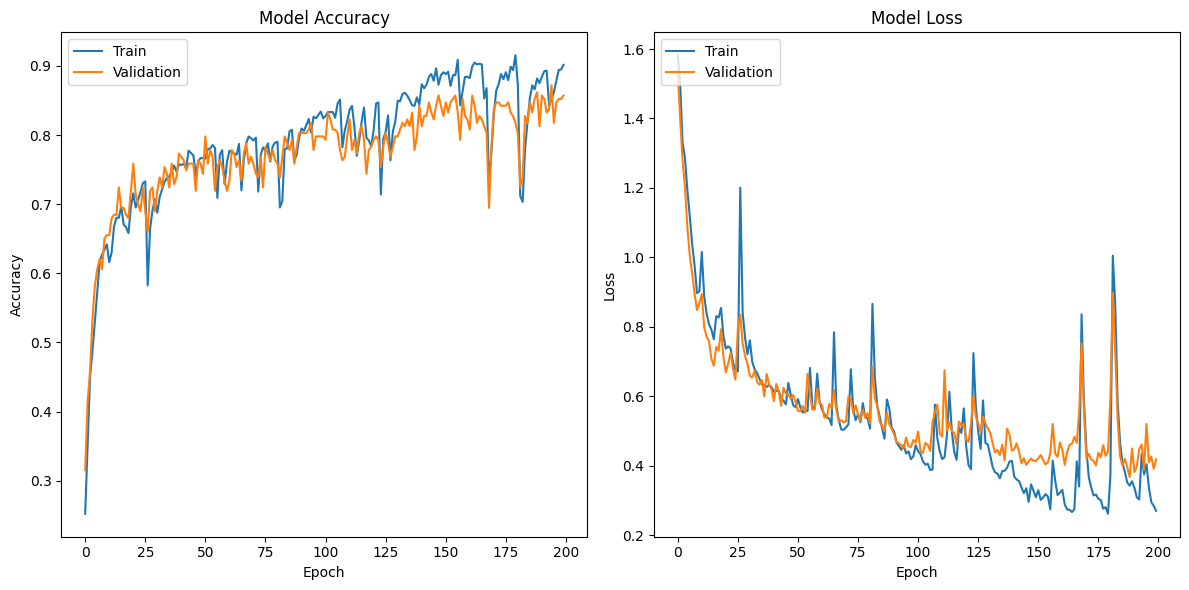

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Validation Accuracy: 85.71%

Fold 4
Epoch 1/200


/home/macreai/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 8s - 413ms/step - accuracy: 0.2843 - loss: 1.5808 - val_accuracy: 0.3596 - val_loss: 1.5105
Epoch 2/200
20/20 - 1s - 51ms/step - accuracy: 0.3714 - loss: 1.4890 - val_accuracy: 0.4680 - val_loss: 1.3742
Epoch 3/200
20/20 - 1s - 45ms/step - accuracy: 0.4486 - loss: 1.3446 - val_accuracy: 0.5025 - val_loss: 1.2544
Epoch 4/200
20/20 - 1s - 31ms/step - accuracy: 0.5177 - loss: 1.2409 - val_accuracy: 0.5517 - val_loss: 1.1407
Epoch 5/200
20/20 - 1s - 29ms/step - accuracy: 0.5670 - loss: 1.1309 - val_accuracy: 0.5517 - val_loss: 1.1322
Epoch 6/200
20/20 - 1s - 29ms/step - accuracy: 0.5563 - loss: 1.1012 - val_accuracy: 0.6207 - val_loss: 1.0336
Epoch 7/200
20/20 - 1s - 29ms/step - accuracy: 0.6031 - loss: 1.0052 - val_accuracy: 0.6059 - val_loss: 1.0035
Epoch 8/200
20/20 - 1s - 38ms/step - accuracy: 0.6039 - loss: 1.0025 - val_accuracy: 0.6404 - val_loss: 0.9445
Epoch 9/200
20/20 - 1s - 32ms/step - accuracy: 0.6335 - loss: 0.9000 - val_accuracy: 0.6355 - val_loss: 0.9265
Epoch 10/200

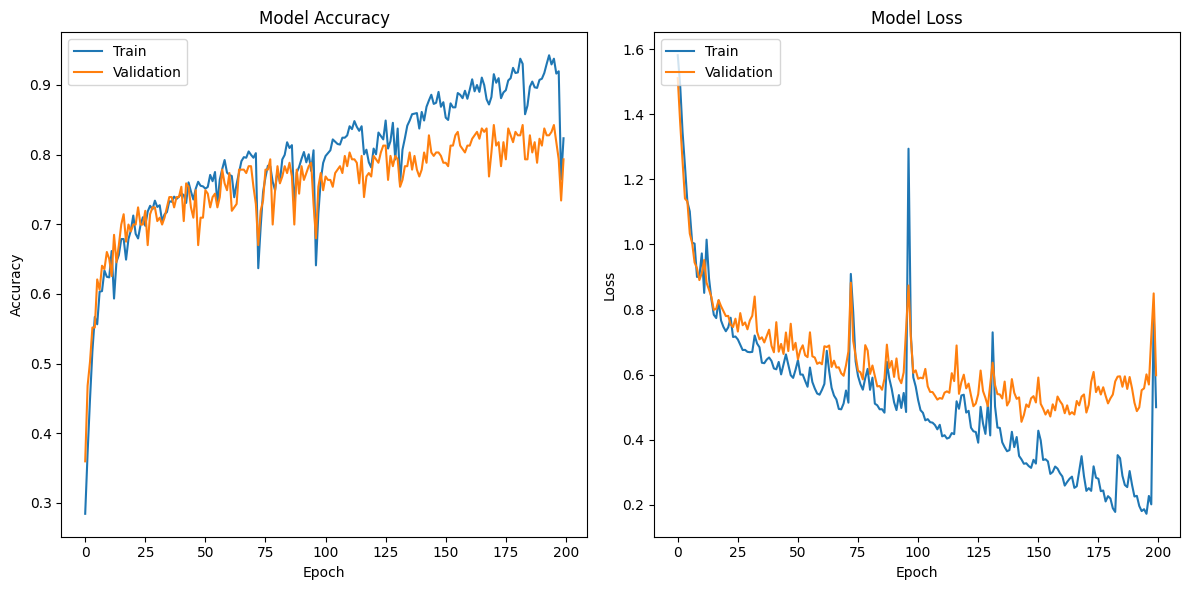

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Validation Accuracy: 79.31%

Fold 5
Epoch 1/200


/home/macreai/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 5s - 272ms/step - accuracy: 0.2605 - loss: 1.5909 - val_accuracy: 0.2611 - val_loss: 1.5517
Epoch 2/200
20/20 - 1s - 28ms/step - accuracy: 0.3205 - loss: 1.5044 - val_accuracy: 0.4089 - val_loss: 1.4155
Epoch 3/200
20/20 - 1s - 27ms/step - accuracy: 0.4256 - loss: 1.3347 - val_accuracy: 0.5369 - val_loss: 1.2269
Epoch 4/200
20/20 - 1s - 27ms/step - accuracy: 0.5103 - loss: 1.2193 - val_accuracy: 0.5911 - val_loss: 1.1158
Epoch 5/200
20/20 - 1s - 31ms/step - accuracy: 0.5678 - loss: 1.1396 - val_accuracy: 0.6207 - val_loss: 1.0269
Epoch 6/200
20/20 - 1s - 37ms/step - accuracy: 0.5908 - loss: 1.0527 - val_accuracy: 0.6355 - val_loss: 0.9230
Epoch 7/200
20/20 - 1s - 37ms/step - accuracy: 0.6270 - loss: 0.9862 - val_accuracy: 0.6305 - val_loss: 0.9050
Epoch 8/200
20/20 - 1s - 39ms/step - accuracy: 0.6097 - loss: 0.9653 - val_accuracy: 0.6305 - val_loss: 0.8897
Epoch 9/200
20/20 - 1s - 31ms/step - accuracy: 0.6385 - loss: 0.9278 - val_accuracy: 0.6404 - val_loss: 0.8309
Epoch 10/200

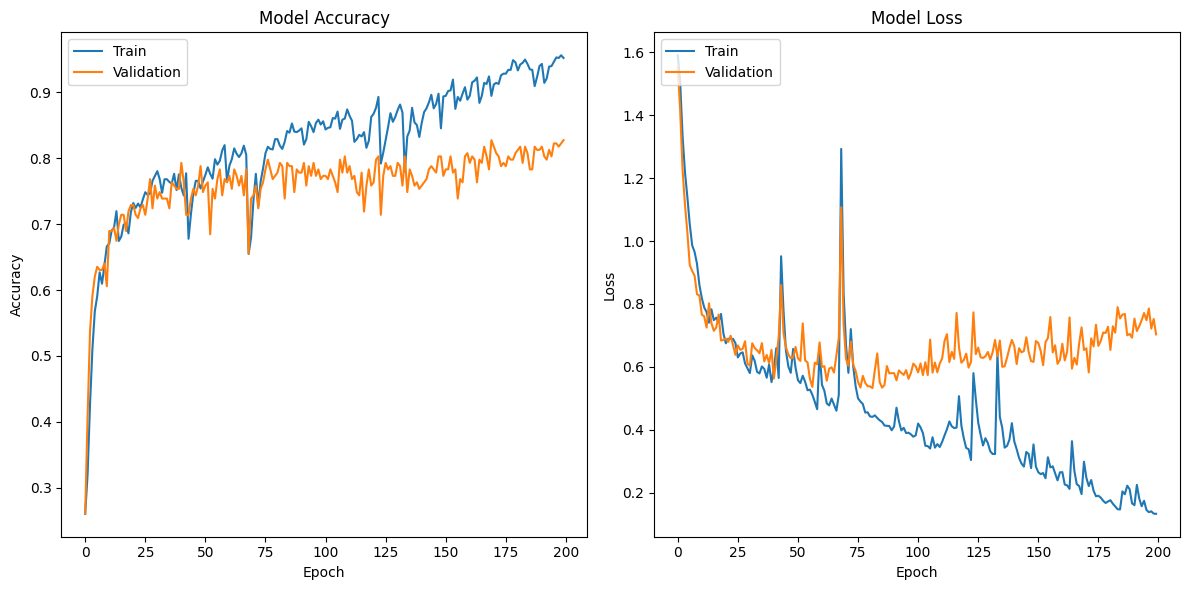

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
Validation Accuracy: 82.76%

Fold 6


/home/macreai/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
20/20 - 8s - 414ms/step - accuracy: 0.2473 - loss: 1.5838 - val_accuracy: 0.3350 - val_loss: 1.5166
Epoch 2/200
20/20 - 1s - 51ms/step - accuracy: 0.3772 - loss: 1.4656 - val_accuracy: 0.4483 - val_loss: 1.3536
Epoch 3/200
20/20 - 1s - 62ms/step - accuracy: 0.4725 - loss: 1.3316 - val_accuracy: 0.5714 - val_loss: 1.1859
Epoch 4/200
20/20 - 1s - 57ms/step - accuracy: 0.5308 - loss: 1.1978 - val_accuracy: 0.5862 - val_loss: 1.0914
Epoch 5/200
20/20 - 1s - 37ms/step - accuracy: 0.5193 - loss: 1.2495 - val_accuracy: 0.5813 - val_loss: 1.0542
Epoch 6/200
20/20 - 1s - 37ms/step - accuracy: 0.5686 - loss: 1.1181 - val_accuracy: 0.6305 - val_loss: 0.9896
Epoch 7/200
20/20 - 1s - 39ms/step - accuracy: 0.6031 - loss: 1.0454 - val_accuracy: 0.6305 - val_loss: 0.9865
Epoch 8/200
20/20 - 1s - 40ms/step - accuracy: 0.6023 - loss: 1.0360 - val_accuracy: 0.6404 - val_loss: 0.9349
Epoch 9/200
20/20 - 1s - 38ms/step - accuracy: 0.6039 - loss: 1.0311 - val_accuracy: 0.6502 - val_loss: 0.9078


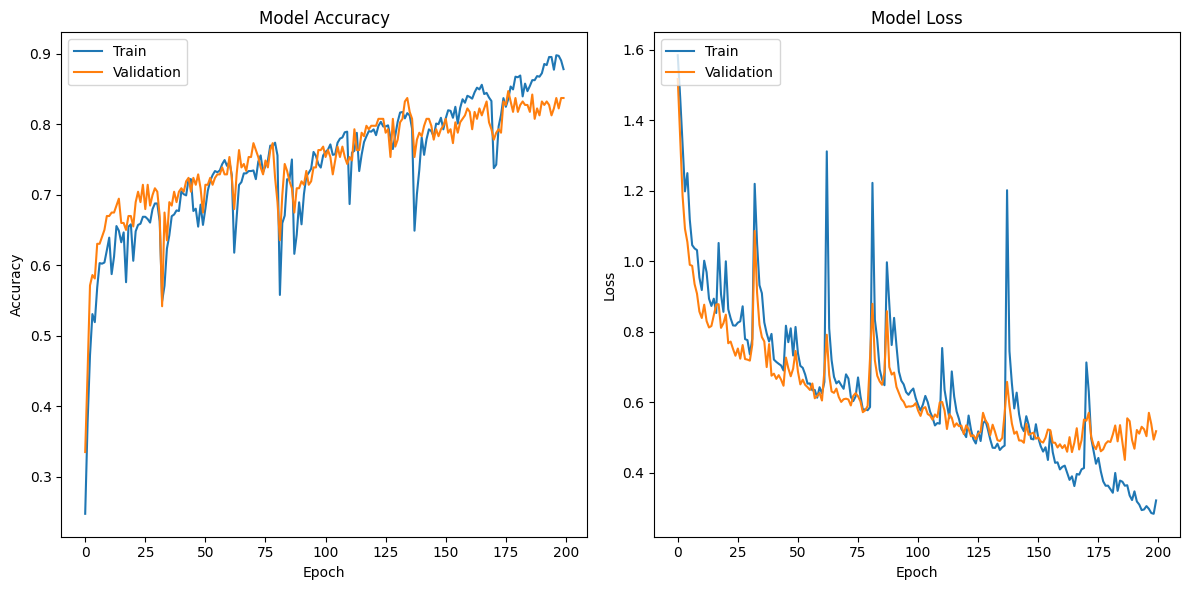

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
Validation Accuracy: 83.74%

Fold 7


/home/macreai/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
20/20 - 8s - 394ms/step - accuracy: 0.2430 - loss: 1.5949 - val_accuracy: 0.3168 - val_loss: 1.5689
Epoch 2/200
20/20 - 1s - 39ms/step - accuracy: 0.3424 - loss: 1.5302 - val_accuracy: 0.4356 - val_loss: 1.4275
Epoch 3/200
20/20 - 1s - 45ms/step - accuracy: 0.4713 - loss: 1.3286 - val_accuracy: 0.5050 - val_loss: 1.2329
Epoch 4/200
20/20 - 1s - 46ms/step - accuracy: 0.5468 - loss: 1.1809 - val_accuracy: 0.5693 - val_loss: 1.1017
Epoch 5/200
20/20 - 1s - 48ms/step - accuracy: 0.5936 - loss: 1.0799 - val_accuracy: 0.6040 - val_loss: 0.9962
Epoch 6/200
20/20 - 1s - 45ms/step - accuracy: 0.5944 - loss: 1.0481 - val_accuracy: 0.6436 - val_loss: 0.9662
Epoch 7/200
20/20 - 1s - 42ms/step - accuracy: 0.6133 - loss: 0.9997 - val_accuracy: 0.6436 - val_loss: 0.9316
Epoch 8/200
20/20 - 1s - 42ms/step - accuracy: 0.6314 - loss: 0.9382 - val_accuracy: 0.6485 - val_loss: 0.9154
Epoch 9/200
20/20 - 1s - 38ms/step - accuracy: 0.6470 - loss: 0.9134 - val_accuracy: 0.6634 - val_loss: 0.8390


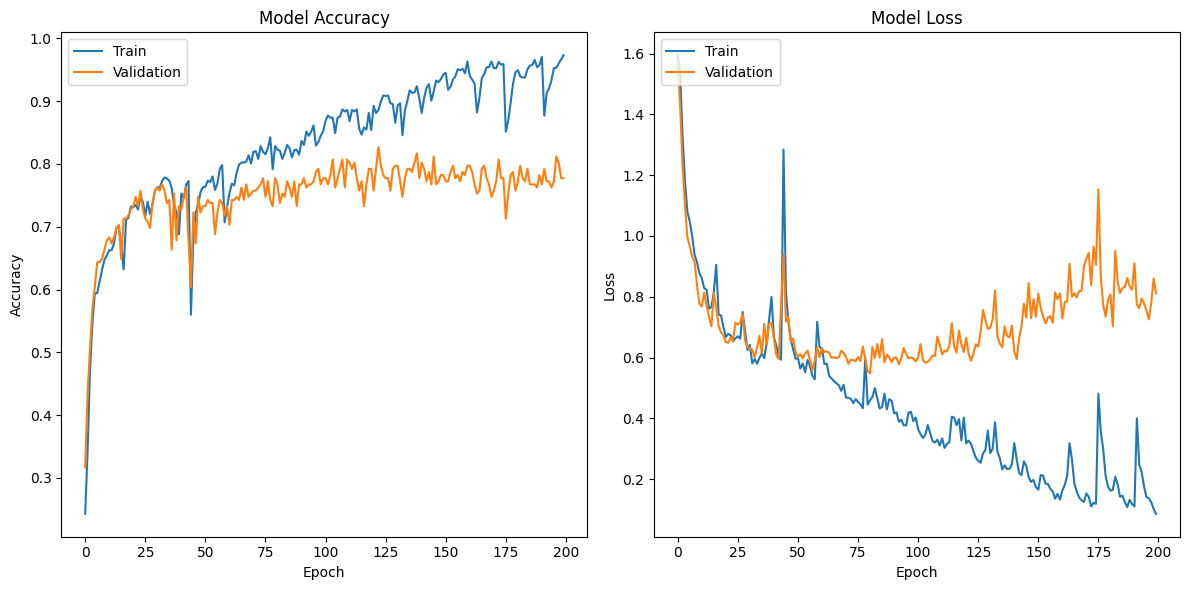

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Validation Accuracy: 77.72%

Akurasi setiap fold (%): ['85.22', '63.05', '85.71', '79.31', '82.76', '83.74', '77.72']
Sensitivitas setiap fold (%): ['83.59', '63.51', '84.94', '80.27', '82.11', '82.65', '78.11']
Spesifisitas setiap fold (%): ['84.08', '62.83', '85.06', '77.85', '81.99', '83.12', '77.28']
F1 Score setiap fold (%): ['83.53', '60.41', '84.87', '78.25', '81.89', '82.13', '77.66']


In [35]:
models_lstm = k_fold_cross_validation_lstm(X_train, y_train)

Dilakukan K-Fold Cross Validation sebanyak 7 dengan waktu komputasi 20m 30.9s, didapatkan Fold ketiga dengan nilai terbaik yaitu Akurasi 85.71%, Sensitivitas 84.94%, Spesifitas 85.06%, dan F1 Score 84.87%

Berikut adalah rata-rata untuk masing-masing metrik:
<br>
- **Akurasi:** 79.64%
- **Sensitivitas:** 79.31%
- **Spesifisitas:** 78.89%
- **F1 Score:** 78.39%

====Fold 1====
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy:  0.7718309859154929
Sensitivity:  0.7900519349494387
Precision:  0.7744075672945406
F1 Score:  0.7765711931751198


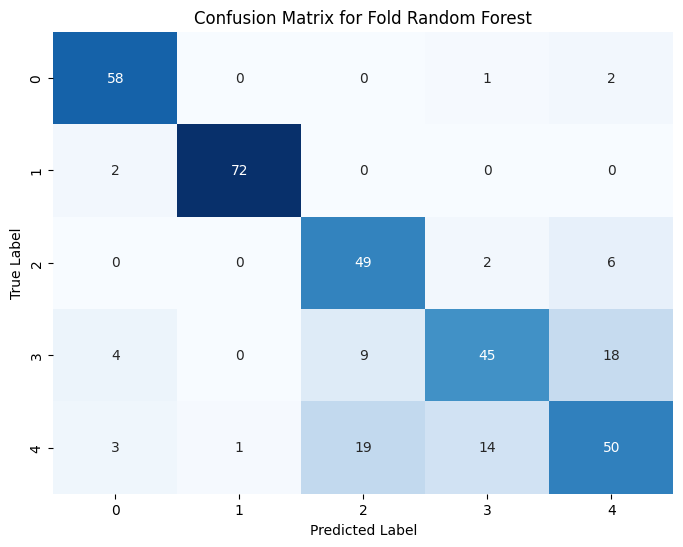

====Fold 2====
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy:  0.6422535211267606
Sensitivity:  0.6668955439030713
Precision:  0.659805622111698
F1 Score:  0.6414310885142873


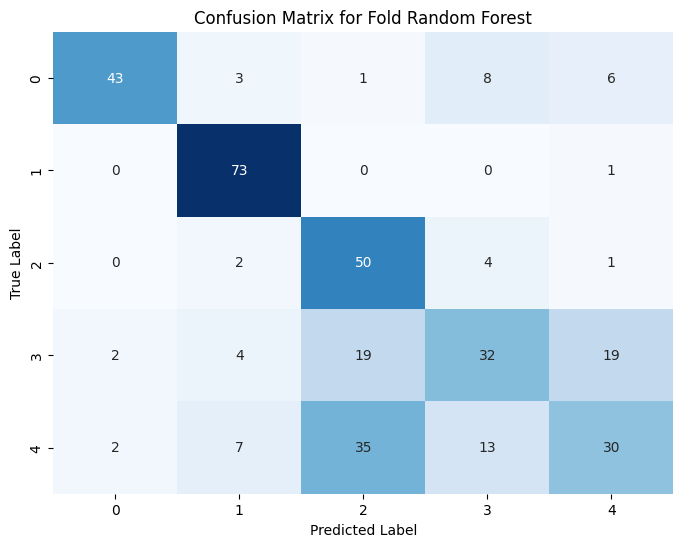

====Fold 3====
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy:  0.7718309859154929
Sensitivity:  0.7962556901014549
Precision:  0.7682769088749624
F1 Score:  0.7744439535687172


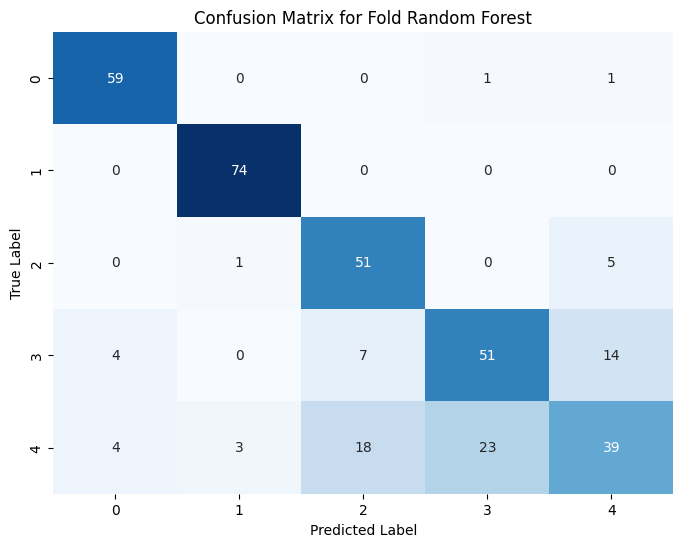

====Fold 4====
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy:  0.7633802816901408
Sensitivity:  0.7905175563233937
Precision:  0.7654746670105684
F1 Score:  0.7648009820273479


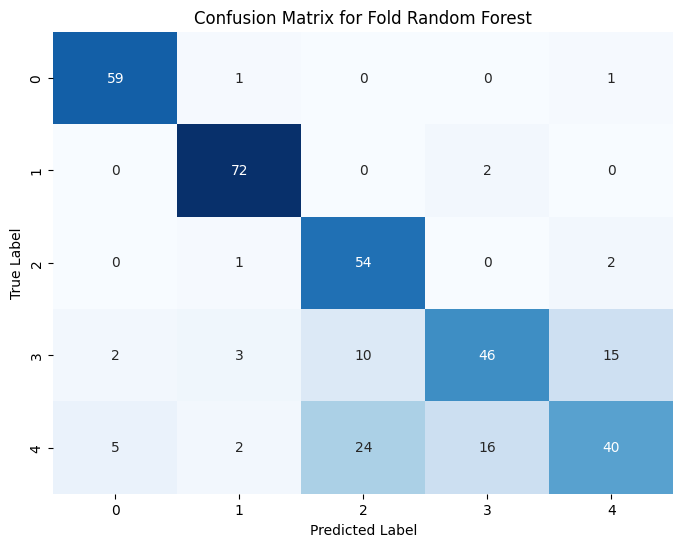

====Fold 5====
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy:  0.8028169014084507
Sensitivity:  0.8234315985677148
Precision:  0.8080378540784491
F1 Score:  0.8053104513726176


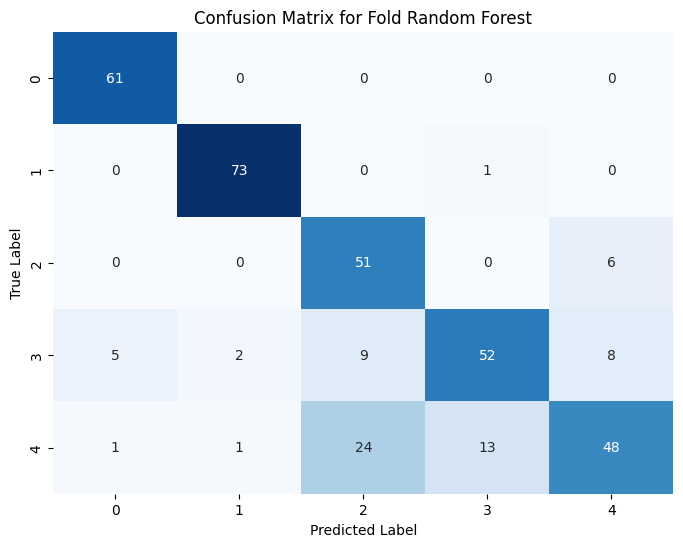

====Fold 6====
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy:  0.7915492957746478
Sensitivity:  0.813832344140874
Precision:  0.7934614813596138
F1 Score:  0.7964433131193207


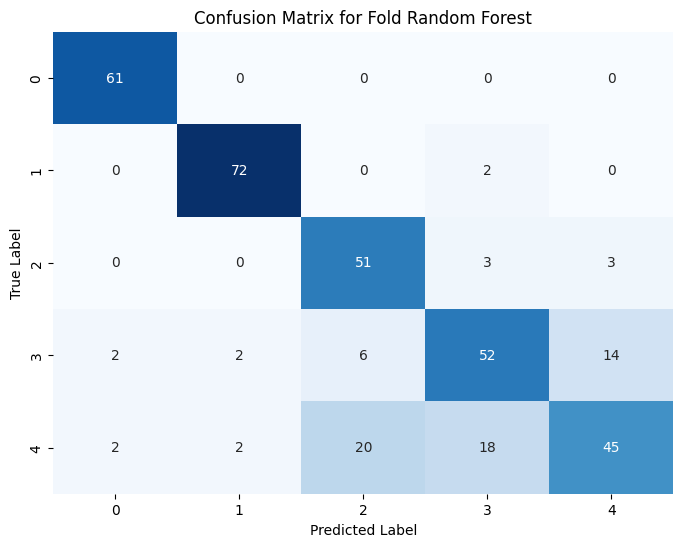

====Fold 7====
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy:  0.828169014084507
Sensitivity:  0.8432675810498547
Precision:  0.8305092081412117
F1 Score:  0.8337717683221486


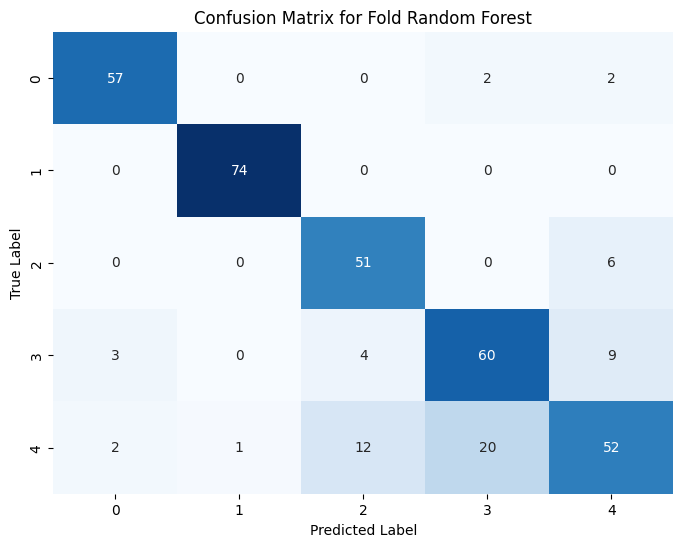

In [39]:
for i in range(len(models_lstm)):
    print(f'====Fold {i+1}====')
    # Prediksi
    y_pred_prob = models_lstm[i].predict(X_test)
    y_pred = y_pred_prob.argmax(axis=-1)

    # Hitung metrik
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Sensitivity: ', recall_score(y_test, y_pred, average='macro'))  # Sensitivitas untuk multiclass
    print('Precision: ', precision_score(y_test, y_pred, average='macro'))  # Precision untuk multiclass
    print('F1 Score: ', f1_score(y_test, y_pred, average='macro'))  # F1 Score untuk multiclass

    # Tampilkan confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix for Fold Random Forest')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Dengan mengujikan semua model Fold pada data yang belum dilihat, model Fold ke-7 memiliki performa terbaik yaitu:

Accuracy:  82.82%
Sensitivity:  84.33%
Precision:  83.05%
F1 Score:  83.38%

Berikut adalah rata-rata untuk masing-masing metrik:

- **Akurasi:** 76.74%
- **Sensitivitas:** 78.93%
- **Presisi:** 77.14%
- **F1 Score:** 77.07%

In [40]:
import pickle

#simpan model random forest
with open('DHD/models_rf.pkl', 'wb') as f:
    pickle.dump(models_rf, f)

#simpan model lstm
with open('DHD/models_lstm.pkl', 'wb') as f:
    pickle.dump(models_lstm, f)

# Kesimpulan

Model Random Forest mengungguli Model LSTM dengan skor Sensitivity:  92.67% dan Precision:  91.58% dibanding LSTM dengan skor Sensitivity:  84.33% dan Precision:  83.05% pada data yang belum dilihat, sekaligus mengungguli sumber daya komputasi dengan alat ukur waktu pada kasus K-Fold Cross Validation sebanyak 7 yaitu Random Forest menghabiskan waktu 11.7s sementara LSTM 20m 30.9s